In [1]:
import os
import timm
import torch
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from huggingface_hub import login

os.environ["HF_HOME"] = r"T:\users\altp\.hf_cache"
os.environ["TRANSFORMERS_CACHE"] = r"T:\users\altp\.hf_cache\transformers"

In [2]:
# load login token from file and login to Hugging Face Hub
with open("../hf_token.txt", "r") as f:
    token = f.read().strip()

login(token=token)


In [3]:
# pretrained=True needed to load UNI2-h weights (and download weights for the first time)
timm_kwargs = {
            'img_size': 224, 
            'patch_size': 14, 
            'depth': 24,
            'num_heads': 24,
            'init_values': 1e-5, 
            'embed_dim': 1536,
            'mlp_ratio': 2.66667*2,
            'num_classes': 0, 
            'no_embed_class': True,
            'mlp_layer': timm.layers.SwiGLUPacked, 
            'act_layer': torch.nn.SiLU, 
            'reg_tokens': 8, 
            'dynamic_img_size': True
        }
model = timm.create_model("hf-hub:MahmoodLab/UNI2-h", pretrained=True, cache_dir=r"T:\users\altp\.hf_cache", **timm_kwargs)
transform = create_transform(**resolve_data_config(model.pretrained_cfg, model=model))
model.eval()

config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

t:\users\altp\uni-thyroid-ct\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in T:\users\altp\.hf_cache\models--MahmoodLab--UNI2-h. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better

pytorch_model.bin:   0%|          | 0.00/2.73G [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (mlp): GluMlp(
        (fc1): Linear(in_features=1536, out_features=8192, bias=True)
        (act): SiLU()
        (drop1): Dropout(p=0.0, inplace=False)
    

In [4]:
import os
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display
import tifffile
import numpy as np

# Set your source directory path
source_dir = Path(r"K:\499-ProjectData\2025\P25-0048_Thyroid_Recurrence\04-Processed_Datasets\split_cleared_dataset")

def get_tiff_files(directory):
    """Get all TIFF files excluding those ending with _tissue"""
    if not directory.exists():
        print(f"Directory does not exist: {directory}")
        return []
    
    tiff_files = []
    for file in sorted(directory.glob("*.tif*")):
        if not file.stem.endswith("_tissue"):
            tiff_files.append(file.name)
    return tiff_files

def load_volume_and_mask(filename):
    """Load the selected volume and its corresponding tissue mask"""
    if not filename:
        print("No file selected")
        return None, None
    
    volume_path = source_dir / filename
    base_name = Path(filename).stem
    tissue_filename = f"{base_name}_tissue.tif"
    tissue_path = source_dir / tissue_filename
    
    print(f"Loading volume: {volume_path}")
    volume = tifffile.imread(volume_path)
    print(f"Volume shape: {volume.shape}, dtype: {volume.dtype}")
    
    if tissue_path.exists():
        print(f"Loading tissue mask: {tissue_path}")
        tissue_mask = tifffile.imread(tissue_path)
        print(f"Tissue mask shape: {tissue_mask.shape}, dtype: {tissue_mask.dtype}")
    else:
        print(f"Warning: Tissue mask not found at {tissue_path}")
        tissue_mask = None
    
    return volume, tissue_mask

def on_file_selected(change):
    """Callback when file is selected"""
    selected_file = change['new']
    if selected_file:
        volume, tissue_mask = load_volume_and_mask(selected_file)
        global current_volume, current_tissue_mask
        current_volume = volume
        current_tissue_mask = tissue_mask

# Get available TIFF files
tiff_files = get_tiff_files(source_dir)
print(f"Found {len(tiff_files)} TIFF files")

# Create and display dropdown
if tiff_files:
    file_dropdown = widgets.Dropdown(
        options=['Select a file...'] + tiff_files,
        value='Select a file...',
        description='TIFF File:',
        disabled=False,
        style={'description_width': '100px'},
        layout=widgets.Layout(width='500px')
    )
    file_dropdown.observe(on_file_selected, names='value')
    display(file_dropdown)
else:
    print(f"No TIFF files found in: {source_dir}")


Found 212 TIFF files


Dropdown(description='TIFF File:', layout=Layout(width='500px'), options=('Select a file...', '002_B05.20964B.…

In [5]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import numpy as np

def plot_slice(slice_idx):
    """Plot a single slice from the volume and tissue mask with overlay"""
    if 'current_volume' not in globals() or current_volume is None:
        print("No volume loaded. Please select a file from the dropdown above.")
        return
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Original volume
    axes[0].imshow(current_volume[slice_idx], cmap='gray')
    axes[0].set_title(f'Volume - Slice {slice_idx}/{current_volume.shape[0]-1}')
    axes[0].axis('off')
    
    # Plot 2: Tissue mask
    if current_tissue_mask is not None:
        axes[1].imshow(current_tissue_mask[slice_idx], cmap='gray')
        axes[1].set_title(f'Tissue Mask - Slice {slice_idx}/{current_tissue_mask.shape[0]-1}')
    else:
        axes[1].text(0.5, 0.5, 'No tissue mask available', 
                    ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('Tissue Mask - Not Available')
    axes[1].axis('off')
    
    # Plot 3: Overlay with grid
    axes[2].imshow(current_volume[slice_idx], cmap='gray')
    
    # Overlay tissue mask with transparency
    if current_tissue_mask is not None:
        mask_overlay = np.ma.masked_where(current_tissue_mask[slice_idx] == 0, current_tissue_mask[slice_idx])
        axes[2].imshow(mask_overlay, cmap='Reds', alpha=0.3)
    
    # Add 224x224 grid
    height, width = current_volume[slice_idx].shape
    
    # Draw vertical lines
    for x in range(0, width, 224):
        axes[2].axvline(x=x, color='cyan', linewidth=1, linestyle='--', alpha=0.7)
    
    # Draw horizontal lines
    for y in range(0, height, 224):
        axes[2].axhline(y=y, color='cyan', linewidth=1, linestyle='--', alpha=0.7)
    
    axes[2].set_title(f'Overlay with 224x224 Grid - Slice {slice_idx}')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Create interactive slider for scrolling through slices
if 'current_volume' in globals() and current_volume is not None:
    depth = current_volume.shape[0]
    interact(plot_slice, 
             slice_idx=IntSlider(min=0, max=depth-1, step=1, value=depth//2, 
                                description='Slice:'))
else:
    print("No volume loaded yet. Please select a file from the dropdown above first.")

interactive(children=(IntSlider(value=52, description='Slice:', max=103), Output()), _dom_classes=('widget-int…

In [6]:
def extract_patches_from_slice(volume_slice, mask_slice, patch_size=224):
    """
    Extract patches from a single slice that contain positive mask pixels.
    
    Returns:
        patches: list of volume patches
        mask_patches: list of mask patches
        positions: list of (slice_idx, y, x) positions
        percentages: list of positive pixel percentages
    """
    height, width = volume_slice.shape
    patches = []
    mask_patches = []
    positions = []
    percentages = []
    
    # Iterate through the image in patch_size steps
    for y in range(0, height - patch_size + 1, patch_size):
        for x in range(0, width - patch_size + 1, patch_size):
            # Extract patches
            volume_patch = volume_slice[y:y+patch_size, x:x+patch_size]
            mask_patch = mask_slice[y:y+patch_size, x:x+patch_size]
            
            # Check if mask has any positive pixels
            positive_pixels = np.sum(mask_patch > 0)
            
            if positive_pixels > 0:
                # Calculate percentage of positive pixels
                total_pixels = patch_size * patch_size
                percentage = (positive_pixels / total_pixels) * 100
                
                patches.append(volume_patch)
                mask_patches.append(mask_patch)
                positions.append((y, x))
                percentages.append(percentage)
    
    return patches, mask_patches, positions, percentages


def extract_patches_from_volume(volume, mask, patch_size=224):
    """
    Extract all patches from the entire 3D volume that contain positive mask pixels.
    
    Returns:
        all_patches: list of volume patches
        all_mask_patches: list of mask patches
        all_positions: list of (slice_idx, y, x) positions
        all_percentages: list of positive pixel percentages
        all_relative_positions: list of (z_rel, y_rel, x_rel) positions relative to volume center
    """
    if volume is None or mask is None:
        print("Volume or mask is None")
        return [], [], [], [], []
    
    all_patches = []
    all_mask_patches = []
    all_positions = []
    all_percentages = []
    all_relative_positions = []
    
    # Get volume dimensions and calculate center
    num_slices, height, width = volume.shape
    volume_center_z = num_slices / 2.0
    volume_center_y = height / 2.0
    volume_center_x = width / 2.0
    
    for slice_idx in range(num_slices):
        patches, mask_patches, positions, percentages = extract_patches_from_slice(
            volume[slice_idx], mask[slice_idx], patch_size
        )
        
        # Add slice index to positions and calculate relative positions
        for y, x in positions:
            positions_3d = (slice_idx, y, x)
            
            # Calculate center of the patch
            patch_center_z = slice_idx
            patch_center_y = y + patch_size / 2.0
            patch_center_x = x + patch_size / 2.0
            
            # Calculate relative position from volume center
            relative_z = patch_center_z - volume_center_z
            relative_y = patch_center_y - volume_center_y
            relative_x = patch_center_x - volume_center_x
            
            all_positions.append(positions_3d)
            all_relative_positions.append((relative_z, relative_y, relative_x))
        
        all_patches.extend(patches)
        all_mask_patches.extend(mask_patches)
        all_percentages.extend(percentages)
    
    return all_patches, all_mask_patches, all_positions, all_percentages, all_relative_positions


# Extract patches from the loaded volume
if 'current_volume' in globals() and current_volume is not None and current_tissue_mask is not None:
    print("Extracting patches...")
    patches, mask_patches, positions, percentages, relative_positions = extract_patches_from_volume(
        current_volume, current_tissue_mask, patch_size=224
    )
    
    print(f"Extracted {len(patches)} patches with positive mask pixels")
    print(f"Percentage range: {min(percentages):.2f}% - {max(percentages):.2f}%")
    print(f"Mean percentage: {np.mean(percentages):.2f}%")
    
    # Convert relative positions to numpy array for easier analysis
    relative_positions_array = np.array(relative_positions)
    print(f"\nRelative position statistics (relative to volume center):")
    print(f"  Z-axis range: {relative_positions_array[:, 0].min():.2f} to {relative_positions_array[:, 0].max():.2f}")
    print(f"  Y-axis range: {relative_positions_array[:, 1].min():.2f} to {relative_positions_array[:, 1].max():.2f}")
    print(f"  X-axis range: {relative_positions_array[:, 2].min():.2f} to {relative_positions_array[:, 2].max():.2f}")
    
    # Store globally for further processing
    global extracted_patches, extracted_mask_patches, patch_positions, patch_percentages, patch_relative_positions
    extracted_patches = patches
    extracted_mask_patches = mask_patches
    patch_positions = positions
    patch_percentages = percentages
    patch_relative_positions = relative_positions
else:
    print("Please load a volume and mask first using the dropdown above.")

Extracting patches...
Extracted 3246 patches with positive mask pixels
Percentage range: 0.00% - 99.93%
Mean percentage: 30.91%

Relative position statistics (relative to volume center):
  Z-axis range: -52.00 to 51.00
  Y-axis range: -506.50 to 389.50
  X-axis range: -703.50 to 640.50
Extracted 3246 patches with positive mask pixels
Percentage range: 0.00% - 99.93%
Mean percentage: 30.91%

Relative position statistics (relative to volume center):
  Z-axis range: -52.00 to 51.00
  Y-axis range: -506.50 to 389.50
  X-axis range: -703.50 to 640.50


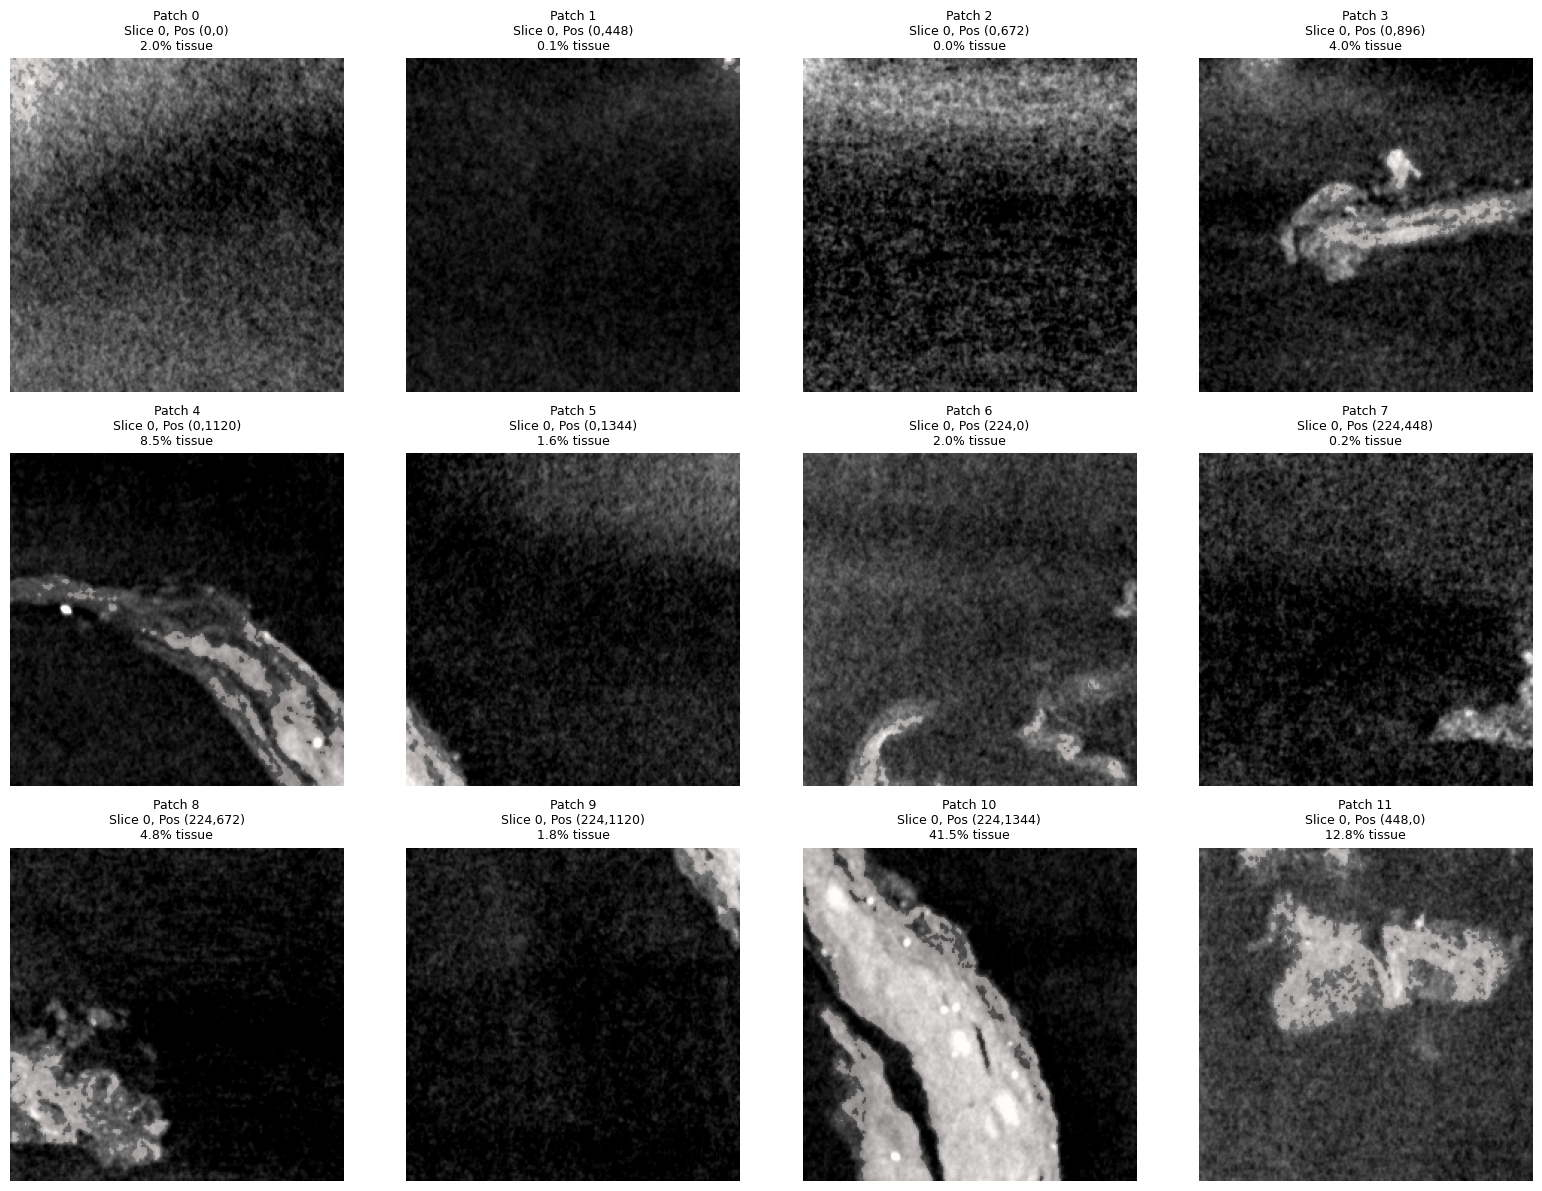


Showing 12 out of 3246 total patches


In [7]:
# Visualize some extracted patches
if 'extracted_patches' in globals() and len(extracted_patches) > 0:
    # Show first 12 patches
    num_to_show = min(12, len(extracted_patches))
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()
    
    for i in range(num_to_show):
        # Show volume patch with mask overlay
        axes[i].imshow(extracted_patches[i], cmap='gray')
        
        # Overlay mask
        mask_overlay = np.ma.masked_where(extracted_mask_patches[i] == 0, extracted_mask_patches[i])
        axes[i].imshow(mask_overlay, cmap='Reds', alpha=0.3)
        
        slice_idx, y, x = patch_positions[i]
        axes[i].set_title(f'Patch {i}\nSlice {slice_idx}, Pos ({y},{x})\n{patch_percentages[i]:.1f}% tissue', 
                         fontsize=9)
        axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(num_to_show, 12):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nShowing {num_to_show} out of {len(extracted_patches)} total patches")
else:
    print("No patches extracted yet. Run the previous cell first.")

In [8]:
from PIL import Image
from tqdm import tqdm

def grayscale_to_rgb(gray_patch):
    """Convert grayscale patch to RGB by replicating the channel 3 times"""
    # Normalize to 0-255 range if needed
    if gray_patch.max() <= 1.0:
        gray_patch = (gray_patch * 255).astype(np.uint8)
    elif gray_patch.dtype != np.uint8:
        # Scale to 0-255 range
        gray_min, gray_max = gray_patch.min(), gray_patch.max()
        if gray_max > gray_min:
            gray_patch = ((gray_patch - gray_min) / (gray_max - gray_min) * 255).astype(np.uint8)
        else:
            gray_patch = np.zeros_like(gray_patch, dtype=np.uint8)
    
    # Stack grayscale image 3 times to create RGB
    rgb_patch = np.stack([gray_patch, gray_patch, gray_patch], axis=-1)
    return Image.fromarray(rgb_patch)


def extract_embeddings(patches, model, transform, batch_size=16, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Extract embeddings from patches using the UNI model.
    
    Args:
        patches: list of grayscale patches (HxW numpy arrays)
        model: the UNI model
        transform: the transform to apply to images
        batch_size: number of patches to process at once
        device: device to run inference on
    
    Returns:
        embeddings: numpy array of shape (num_patches, embedding_dim)
    """
    model = model.to(device)
    model.eval()
    
    all_embeddings = []
    
    # Process patches in batches
    for i in tqdm(range(0, len(patches), batch_size), desc="Extracting embeddings"):
        batch_patches = patches[i:i+batch_size]
        
        # Convert grayscale to RGB and apply transforms
        batch_tensors = []
        for patch in batch_patches:
            # Convert to RGB (replicate channels)
            rgb_image = grayscale_to_rgb(patch)
            
            # Apply model transforms
            tensor = transform(rgb_image)
            batch_tensors.append(tensor)
        
        # Stack into batch
        batch = torch.stack(batch_tensors).to(device)
        
        # Extract embeddings
        with torch.no_grad():
            embeddings = model(batch)
        
        all_embeddings.append(embeddings.cpu().numpy())
    
    # Concatenate all embeddings
    all_embeddings = np.concatenate(all_embeddings, axis=0)
    return all_embeddings


# Extract embeddings from patches
if 'extracted_patches' in globals() and len(extracted_patches) > 0:
    print(f"Extracting embeddings from {len(extracted_patches)} patches...")
    print(f"Using device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
    
    embeddings = extract_embeddings(
        extracted_patches, 
        model, 
        transform, 
        batch_size=16
    )
    
    print(f"Embeddings shape: {embeddings.shape}")
    print(f"Embedding dimension: {embeddings.shape[1]}")
    
    # Store globally
    global patch_embeddings
    patch_embeddings = embeddings
    
    print("\nEmbedding statistics:")
    print(f"  Mean: {embeddings.mean():.4f}")
    print(f"  Std: {embeddings.std():.4f}")
    print(f"  Min: {embeddings.min():.4f}")
    print(f"  Max: {embeddings.max():.4f}")
else:
    print("No patches extracted yet. Run the patch extraction cell first.")

Extracting embeddings from 3246 patches...
Using device: cuda


Extracting embeddings: 100%|██████████| 203/203 [02:03<00:00,  1.64it/s]

Embeddings shape: (3246, 1536)
Embedding dimension: 1536

Embedding statistics:
  Mean: 0.0029
  Std: 0.4171
  Min: -2.5119
  Max: 2.0176


In [13]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Import UMAP properly
try:
    from umap import UMAP
    umap_available = True
    print("✓ UMAP imported successfully")
except ImportError as e:
    print(f"✗ UMAP import failed: {e}")
    print("Run the installation cell above and restart the kernel.")
    umap_available = False

# Perform dimensionality reduction
if 'patch_embeddings' in globals() and patch_embeddings is not None:
    print("\nPerforming dimensionality reduction...")
    print(f"Input embeddings shape: {patch_embeddings.shape}")
    print(f"Number of samples: {patch_embeddings.shape[0]}")
    
    # Adjust parameters based on number of samples
    n_samples = patch_embeddings.shape[0]
    
    # PCA
    print("\nRunning PCA...")
    try:
        pca = PCA(n_components=2, random_state=42)
        embeddings_pca = pca.fit_transform(patch_embeddings)
        print(f"✓ PCA output shape: {embeddings_pca.shape}")
        print(f"  Explained variance ratio: {pca.explained_variance_ratio_}")
        print(f"  Total variance explained: {pca.explained_variance_ratio_.sum():.4f}")
    except Exception as e:
        print(f"✗ PCA error: {e}")
        embeddings_pca = None
    
    # t-SNE parameters
    tsne_perplexity = min(30, n_samples - 1)  # perplexity must be less than n_samples
    print(f"\nt-SNE perplexity: {tsne_perplexity}")
    
    # t-SNE
    print("\nRunning t-SNE...")
    try:
        tsne = TSNE(
            n_components=2, 
            random_state=42, 
            perplexity=tsne_perplexity, 
            max_iter=1000, 
            verbose=1
        )
        embeddings_tsne = tsne.fit_transform(patch_embeddings)
        print(f"✓ t-SNE output shape: {embeddings_tsne.shape}")
    except Exception as e:
        print(f"✗ t-SNE error: {e}")
        embeddings_tsne = None
    
    # UMAP
    if umap_available:
        umap_n_neighbors = min(15, n_samples - 1)  # n_neighbors must be less than n_samples
        print(f"\nUMAP n_neighbors: {umap_n_neighbors}")
        
        print("\nRunning UMAP...")
        try:
            # Create UMAP object with proper parameters
            reducer = UMAP(
                n_components=2, 
                random_state=42, 
                n_neighbors=umap_n_neighbors, 
                min_dist=0.1,
                metric='euclidean',
                verbose=True
            )
            embeddings_umap = reducer.fit_transform(patch_embeddings)
            print(f"✓ UMAP output shape: {embeddings_umap.shape}")
        except Exception as e:
            print(f"✗ UMAP error: {e}")
            import traceback
            traceback.print_exc()
            embeddings_umap = None
    else:
        print("\n⚠ UMAP not available - skipping UMAP reduction")
        embeddings_umap = None
    
    # Store globally
    if embeddings_pca is not None or embeddings_tsne is not None or embeddings_umap is not None:
        global embeddings_2d_pca, embeddings_2d_tsne, embeddings_2d_umap, pca_model
        embeddings_2d_pca = embeddings_pca
        embeddings_2d_tsne = embeddings_tsne
        embeddings_2d_umap = embeddings_umap
        if embeddings_pca is not None:
            pca_model = pca
        print("\n✓ Dimensionality reduction complete!")
    else:
        print("\n✗ All methods failed. Please check the error messages above.")
else:
    print("No embeddings found. Please run the embedding extraction cell first.")

✓ UMAP imported successfully

Performing dimensionality reduction...
Input embeddings shape: (3246, 1536)
Number of samples: 3246

Running PCA...
✓ PCA output shape: (3246, 2)
  Explained variance ratio: [0.24134521 0.10832799]
  Total variance explained: 0.3497

t-SNE perplexity: 30

Running t-SNE...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3246 samples in 0.004s...
[t-SNE] Computed neighbors for 3246 samples in 0.326s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3246
[t-SNE] Computed conditional probabilities for sample 2000 / 3246
[t-SNE] Computed conditional probabilities for sample 3000 / 3246
[t-SNE] Computed conditional probabilities for sample 3246 / 3246
[t-SNE] Mean sigma: 3.757731
[t-SNE] Computed neighbors for 3246 samples in 0.326s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3246
[t-SNE] Computed conditional probabilities for sample 2000 / 3246
[t-SNE] Computed conditional probabilities for sample 3000 / 3246
[t-SNE] 

u:\users\altp\uni-thyroid-ct\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Tue Oct 21 16:05:21 2025 Finding Nearest Neighbors
Tue Oct 21 16:05:22 2025 Finished Nearest Neighbor Search
Tue Oct 21 16:05:22 2025 Construct embedding
Tue Oct 21 16:05:22 2025 Finished Nearest Neighbor Search
Tue Oct 21 16:05:22 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Oct 21 16:05:36 2025 Finished embedding
✓ UMAP output shape: (3246, 2)

✓ Dimensionality reduction complete!
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Oct 21 16:05:36 2025 Finished embedding
✓ UMAP output shape: (3246, 2)

✓ Dimensionality reduction complete!


In [14]:
# Interactive visualization with dropdown for color variable selection
import ipywidgets as widgets
from IPython.display import display

def create_visualization(color_by='Tissue Mask %'):
    """Create visualization colored by selected variable"""
    if 'patch_percentages' not in globals():
        print("Please run the patch extraction cell first.")
        return
    
    # Check which methods succeeded
    has_pca = 'embeddings_2d_pca' in globals() and embeddings_2d_pca is not None
    has_tsne = 'embeddings_2d_tsne' in globals() and embeddings_2d_tsne is not None
    has_umap = 'embeddings_2d_umap' in globals() and embeddings_2d_umap is not None
    
    if not has_pca and not has_tsne and not has_umap:
        print("No dimensionality reduction results available. Please run the previous cell first.")
        return
    
    # Prepare color data based on selection
    percentages_array = np.array(patch_percentages)
    positions_array = np.array(patch_positions)
    relative_positions_array = np.array(patch_relative_positions)
    
    color_options = {
        'Tissue Mask %': percentages_array,
        'Slice Index (Z)': positions_array[:, 0],
        'Y Position': positions_array[:, 1],
        'X Position': positions_array[:, 2],
        'Relative Z': relative_positions_array[:, 0],
        'Relative Y': relative_positions_array[:, 1],
        'Relative X': relative_positions_array[:, 2],
        'Distance from Center': np.sqrt(np.sum(relative_positions_array**2, axis=1))
    }
    
    color_data = color_options[color_by]
    
    # Determine number of plots
    n_plots = int(has_pca) + int(has_tsne) + int(has_umap)
    
    # Create figure
    fig, axes = plt.subplots(1, n_plots, figsize=(8*n_plots, 7))
    if n_plots == 1:
        axes = [axes]
    
    plot_idx = 0
    
    # PCA plot
    if has_pca:
        scatter_pca = axes[plot_idx].scatter(
            embeddings_2d_pca[:, 0], 
            embeddings_2d_pca[:, 1],
            c=color_data,
            cmap='viridis',
            s=20,
            alpha=0.6
        )
        
        # Add variance explained to title
        if 'pca_model' in globals():
            var_exp = pca_model.explained_variance_ratio_
            title = f'PCA Visualization\n(PC1: {var_exp[0]:.2%}, PC2: {var_exp[1]:.2%})\nColored by {color_by}'
        else:
            title = f'PCA Visualization\nColored by {color_by}'
        
        axes[plot_idx].set_title(title, fontsize=13)
        axes[plot_idx].set_xlabel('PC1', fontsize=11)
        axes[plot_idx].set_ylabel('PC2', fontsize=11)
        cbar_pca = plt.colorbar(scatter_pca, ax=axes[plot_idx])
        cbar_pca.set_label(color_by, fontsize=11)
        axes[plot_idx].grid(True, alpha=0.3)
        plot_idx += 1
    
    # t-SNE plot
    if has_tsne:
        scatter1 = axes[plot_idx].scatter(
            embeddings_2d_tsne[:, 0], 
            embeddings_2d_tsne[:, 1],
            c=color_data,
            cmap='viridis',
            s=20,
            alpha=0.6
        )
        axes[plot_idx].set_title(f't-SNE Visualization\nColored by {color_by}', fontsize=13)
        axes[plot_idx].set_xlabel('t-SNE Component 1', fontsize=11)
        axes[plot_idx].set_ylabel('t-SNE Component 2', fontsize=11)
        cbar1 = plt.colorbar(scatter1, ax=axes[plot_idx])
        cbar1.set_label(color_by, fontsize=11)
        axes[plot_idx].grid(True, alpha=0.3)
        plot_idx += 1
    
    # UMAP plot
    if has_umap:
        scatter2 = axes[plot_idx].scatter(
            embeddings_2d_umap[:, 0], 
            embeddings_2d_umap[:, 1],
            c=color_data,
            cmap='viridis',
            s=20,
            alpha=0.6
        )
        axes[plot_idx].set_title(f'UMAP Visualization\nColored by {color_by}', fontsize=13)
        axes[plot_idx].set_xlabel('UMAP Component 1', fontsize=11)
        axes[plot_idx].set_ylabel('UMAP Component 2', fontsize=11)
        cbar2 = plt.colorbar(scatter2, ax=axes[plot_idx])
        cbar2.set_label(color_by, fontsize=11)
        axes[plot_idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nVisualized {len(color_data)} patches")
    print(f"{color_by} range: {color_data.min():.2f} to {color_data.max():.2f}")
    print(f"{color_by} mean: {color_data.mean():.2f}")

# Create dropdown widget
if 'patch_percentages' in globals():
    color_dropdown = widgets.Dropdown(
        options=[
            'Tissue Mask %',
            'Slice Index (Z)',
            'Y Position',
            'X Position',
            'Relative Z',
            'Relative Y',
            'Relative X',
            'Distance from Center'
        ],
        value='Tissue Mask %',
        description='Color by:',
        disabled=False,
        style={'description_width': '100px'},
        layout=widgets.Layout(width='300px')
    )
    
    # Create interactive widget
    interactive_plot = widgets.interactive(create_visualization, color_by=color_dropdown)
    display(interactive_plot)
else:
    print("Please run the patch extraction cell first.")

interactive(children=(Dropdown(description='Color by:', layout=Layout(width='300px'), options=('Tissue Mask %'…

Analyzing PCA variance distribution...


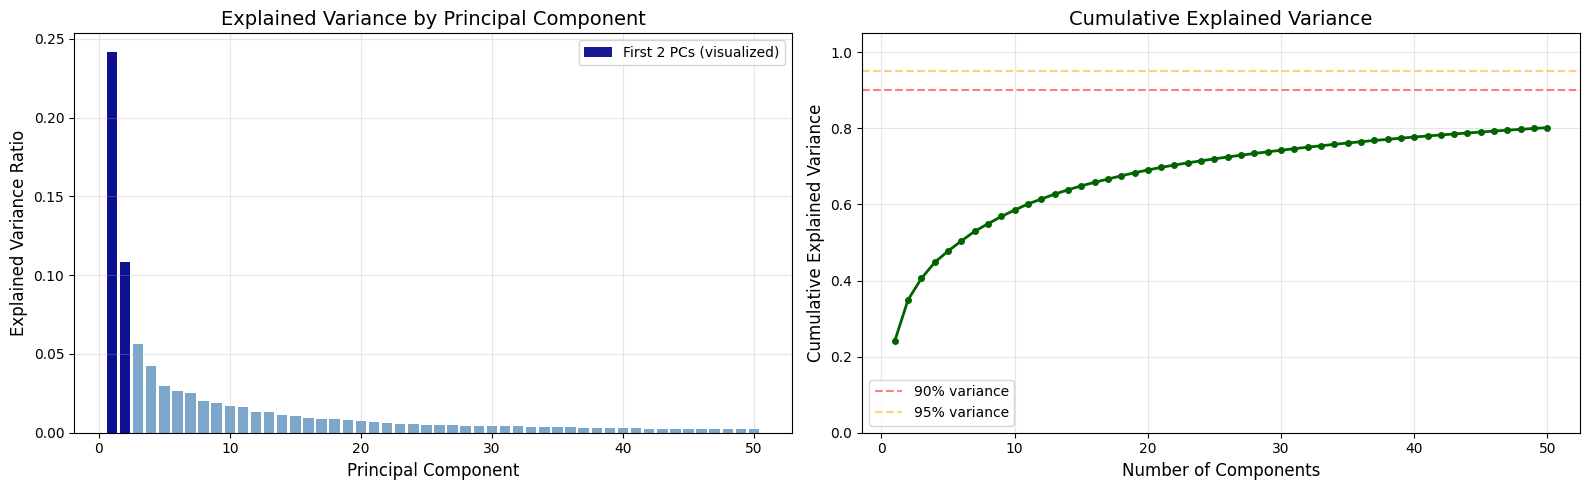


PCA Statistics (using 50 components):
  First 2 components explain: 0.3497 (34.97%) of variance
  First 10 components explain: 0.5853 (58.53%) of variance
  Components for 90% variance: 1
  Components for 95% variance: 1


In [15]:
# Analyze PCA components - Explained Variance
if 'pca_model' in globals() and pca_model is not None:
    # Fit PCA with more components to see full variance distribution
    print("Analyzing PCA variance distribution...")
    n_components_to_analyze = min(50, patch_embeddings.shape[0], patch_embeddings.shape[1])
    
    pca_full = PCA(n_components=n_components_to_analyze, random_state=42)
    pca_full.fit(patch_embeddings)
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Plot 1: Explained variance ratio per component
    axes[0].bar(range(1, len(pca_full.explained_variance_ratio_) + 1), 
                pca_full.explained_variance_ratio_,
                alpha=0.7,
                color='steelblue')
    axes[0].set_xlabel('Principal Component', fontsize=12)
    axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
    axes[0].set_title('Explained Variance by Principal Component', fontsize=14)
    axes[0].grid(True, alpha=0.3)
    
    # Highlight first 2 components
    axes[0].bar([1, 2], pca_full.explained_variance_ratio_[:2], 
                alpha=0.9, color='darkblue', label='First 2 PCs (visualized)')
    axes[0].legend()
    
    # Plot 2: Cumulative explained variance
    cumulative_var = np.cumsum(pca_full.explained_variance_ratio_)
    axes[1].plot(range(1, len(cumulative_var) + 1), cumulative_var, 
                 'o-', linewidth=2, markersize=4, color='darkgreen')
    axes[1].axhline(y=0.9, color='r', linestyle='--', alpha=0.5, label='90% variance')
    axes[1].axhline(y=0.95, color='orange', linestyle='--', alpha=0.5, label='95% variance')
    axes[1].set_xlabel('Number of Components', fontsize=12)
    axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
    axes[1].set_title('Cumulative Explained Variance', fontsize=14)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    axes[1].set_ylim([0, 1.05])
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nPCA Statistics (using {n_components_to_analyze} components):")
    print(f"  First 2 components explain: {cumulative_var[1]:.4f} ({cumulative_var[1]*100:.2f}%) of variance")
    print(f"  First 10 components explain: {cumulative_var[9]:.4f} ({cumulative_var[9]*100:.2f}%) of variance")
    
    # Find components needed for 90% and 95% variance
    n_90 = np.argmax(cumulative_var >= 0.90) + 1
    n_95 = np.argmax(cumulative_var >= 0.95) + 1
    print(f"  Components for 90% variance: {n_90}")
    print(f"  Components for 95% variance: {n_95}")
    
    # Store the full PCA model
    global pca_full_model
    pca_full_model = pca_full
else:
    print("PCA not available. Please run the dimensionality reduction cell first.")

In [ ]:
# Create additional visualizations with different color schemes
if 'embeddings_2d_tsne' in globals() and 'embeddings_2d_umap' in globals():
    percentages_array = np.array(patch_percentages)
    
    # Create figure with multiple color schemes
    fig = plt.figure(figsize=(20, 12))
    
    # Define different colormaps to try
    colormaps = ['viridis', 'plasma', 'coolwarm', 'RdYlGn']
    
    for idx, cmap_name in enumerate(colormaps):
        # t-SNE subplot
        ax1 = plt.subplot(2, 4, idx + 1)
        scatter1 = ax1.scatter(
            embeddings_2d_tsne[:, 0], 
            embeddings_2d_tsne[:, 1],
            c=percentages_array,
            cmap=cmap_name,
            s=15,
            alpha=0.6
        )
        ax1.set_title(f't-SNE ({cmap_name})', fontsize=11)
        ax1.set_xlabel('Component 1', fontsize=9)
        ax1.set_ylabel('Component 2', fontsize=9)
        plt.colorbar(scatter1, ax=ax1, label='Tissue %')
        ax1.grid(True, alpha=0.3)
        
        # UMAP subplot
        ax2 = plt.subplot(2, 4, idx + 5)
        scatter2 = ax2.scatter(
            embeddings_2d_umap[:, 0], 
            embeddings_2d_umap[:, 1],
            c=percentages_array,
            cmap=cmap_name,
            s=15,
            alpha=0.6
        )
        ax2.set_title(f'UMAP ({cmap_name})', fontsize=11)
        ax2.set_xlabel('Component 1', fontsize=9)
        ax2.set_ylabel('Component 2', fontsize=9)
        plt.colorbar(scatter2, ax=ax2, label='Tissue %')
        ax2.grid(True, alpha=0.3)
    
    plt.suptitle('Embedding Visualizations with Different Color Schemes', fontsize=16, y=0.995)
    plt.tight_layout()
    plt.show()
else:
    print("Please run the dimensionality reduction cell first.")

# Batch Processing: Analyze All Volumes

Process all volumes in the dataset to extract patches with tissue and invasion information.

In [16]:
# Batch processing: Extract patches from all volumes with invasion information
from pathlib import Path
import tifffile
import numpy as np
from tqdm import tqdm

def normalize_volume_zscore(volume):
    """
    Apply z-score normalization to a volume.
    
    Args:
        volume: 3D numpy array
    
    Returns:
        normalized_volume: z-score normalized volume
    """
    mean = np.mean(volume)
    std = np.std(volume)
    
    # Avoid division by zero
    if std == 0:
        return volume - mean
    
    normalized = (volume - mean) / std
    return normalized

def get_all_volume_files(directory):
    """Get all volume files (excluding _tissue and _mask suffixes)"""
    if not directory.exists():
        print(f"Directory does not exist: {directory}")
        return []
    
    volume_files = []
    for file in sorted(directory.glob("*.tif*")):
        stem = file.stem
        if not stem.endswith("_tissue") and not stem.endswith("_mask"):
            volume_files.append(file.name)
    return volume_files

def extract_patches_from_volume_with_invasion(volume, tissue_mask, invasion_mask, patch_size=224):
    """
    Extract patches from volume with both tissue and invasion information.
    Volume should already be normalized before calling this function.
    
    Returns:
        all_patches: list of volume patches
        all_mask_patches: list of tissue mask patches
        all_positions: list of (slice_idx, y, x) positions
        all_tissue_percentages: list of tissue pixel percentages
        all_relative_positions: list of (z_rel, y_rel, x_rel) positions relative to volume center
        all_has_invasion: list of booleans indicating if patch contains invasion
        all_invasion_percentages: list of invasion pixel percentages
    """
    if volume is None or tissue_mask is None:
        return [], [], [], [], [], [], []
    
    all_patches = []
    all_mask_patches = []
    all_positions = []
    all_tissue_percentages = []
    all_relative_positions = []
    all_has_invasion = []
    all_invasion_percentages = []
    
    # Get volume dimensions and calculate center
    num_slices, height, width = volume.shape
    volume_center_z = num_slices / 2.0
    volume_center_y = height / 2.0
    volume_center_x = width / 2.0
    
    for slice_idx in range(num_slices):
        # Extract patches for this slice
        for y in range(0, height - patch_size + 1, patch_size):
            for x in range(0, width - patch_size + 1, patch_size):
                # Extract patches
                volume_patch = volume[slice_idx, y:y+patch_size, x:x+patch_size]
                tissue_patch = tissue_mask[slice_idx, y:y+patch_size, x:x+patch_size]
                
                # Check if tissue mask has any positive pixels
                tissue_positive_pixels = np.sum(tissue_patch > 0)
                
                if tissue_positive_pixels > 0:
                    # Calculate tissue percentage
                    total_pixels = patch_size * patch_size
                    tissue_percentage = (tissue_positive_pixels / total_pixels) * 100
                    
                    # Check invasion if mask is available
                    has_invasion = False
                    invasion_percentage = 0.0
                    
                    if invasion_mask is not None:
                        invasion_patch = invasion_mask[slice_idx, y:y+patch_size, x:x+patch_size]
                        invasion_positive_pixels = np.sum(invasion_patch > 0)
                        
                        if invasion_positive_pixels > 0:
                            has_invasion = True
                            invasion_percentage = (invasion_positive_pixels / total_pixels) * 100
                    
                    # Calculate center of the patch and relative position
                    patch_center_z = slice_idx
                    patch_center_y = y + patch_size / 2.0
                    patch_center_x = x + patch_size / 2.0
                    
                    relative_z = patch_center_z - volume_center_z
                    relative_y = patch_center_y - volume_center_y
                    relative_x = patch_center_x - volume_center_x
                    
                    # Store results
                    all_patches.append(volume_patch)
                    all_mask_patches.append(tissue_patch)
                    all_positions.append((slice_idx, y, x))
                    all_tissue_percentages.append(tissue_percentage)
                    all_relative_positions.append((relative_z, relative_y, relative_x))
                    all_has_invasion.append(has_invasion)
                    all_invasion_percentages.append(invasion_percentage)
    
    return (all_patches, all_mask_patches, all_positions, all_tissue_percentages, 
            all_relative_positions, all_has_invasion, all_invasion_percentages)


# Process all volumes
print("=" * 80)
print("BATCH PROCESSING: Extracting patches from all volumes")
print("=" * 80)

volume_files = get_all_volume_files(source_dir)
print(f"\nFound {len(volume_files)} volume files to process")

# Storage for all data across volumes
all_volumes_data = {
    'patches': [],
    'tissue_mask_patches': [],
    'positions': [],
    'tissue_percentages': [],
    'relative_positions': [],
    'has_invasion': [],
    'invasion_percentages': [],
    'volume_names': [],
    'volume_indices': []
}

# Process each volume
for vol_idx, volume_file in enumerate(tqdm(volume_files, desc="Processing volumes")):
    try:
        # Load volume
        volume_path = source_dir / volume_file
        volume = tifffile.imread(volume_path)
        
        # Apply z-score normalization
        print(f"\n  Volume {vol_idx}: {volume_file}")
        print(f"    Original - Mean: {volume.mean():.2f}, Std: {volume.std():.2f}, Range: [{volume.min():.2f}, {volume.max():.2f}]")
        
        volume_normalized = normalize_volume_zscore(volume)
        
        print(f"    Normalized - Mean: {volume_normalized.mean():.4f}, Std: {volume_normalized.std():.4f}, Range: [{volume_normalized.min():.2f}, {volume_normalized.max():.2f}]")
        
        # Load tissue mask
        base_name = Path(volume_file).stem
        tissue_filename = f"{base_name}_tissue.tif"
        tissue_path = source_dir / tissue_filename
        
        if not tissue_path.exists():
            print(f"    ⚠ Warning: Tissue mask not found, skipping...")
            continue
        
        tissue_mask = tifffile.imread(tissue_path)
        
        # Load invasion mask if available
        invasion_filename = f"{base_name}_mask.tif"
        invasion_path = source_dir / invasion_filename
        
        if invasion_path.exists():
            invasion_mask = tifffile.imread(invasion_path)
            print(f"    ✓ Invasion mask found")
        else:
            invasion_mask = None
            print(f"    ℹ No invasion mask")
        
        # Extract patches from normalized volume
        (patches, mask_patches, positions, tissue_pcts, 
         rel_pos, has_inv, inv_pcts) = extract_patches_from_volume_with_invasion(
            volume_normalized, tissue_mask, invasion_mask, patch_size=224
        )
        
        print(f"    Extracted {len(patches)} patches")
        
        # Store data with volume information
        all_volumes_data['patches'].extend(patches)
        all_volumes_data['tissue_mask_patches'].extend(mask_patches)
        all_volumes_data['positions'].extend(positions)
        all_volumes_data['tissue_percentages'].extend(tissue_pcts)
        all_volumes_data['relative_positions'].extend(rel_pos)
        all_volumes_data['has_invasion'].extend(has_inv)
        all_volumes_data['invasion_percentages'].extend(inv_pcts)
        all_volumes_data['volume_names'].extend([base_name] * len(patches))
        all_volumes_data['volume_indices'].extend([vol_idx] * len(patches))
        
    except Exception as e:
        print(f"\n✗ Error processing {volume_file}: {e}")
        import traceback
        traceback.print_exc()
        continue

# Summary statistics
print("\n" + "=" * 80)
print("BATCH PROCESSING COMPLETE")
print("=" * 80)
print(f"\nTotal patches extracted: {len(all_volumes_data['patches'])}")
print(f"Number of volumes processed: {len(set(all_volumes_data['volume_names']))}")

# Invasion statistics
has_invasion_array = np.array(all_volumes_data['has_invasion'])
invasion_pct_array = np.array(all_volumes_data['invasion_percentages'])

n_with_invasion = np.sum(has_invasion_array)
n_without_invasion = len(has_invasion_array) - n_with_invasion

print(f"\nInvasion Statistics:")
print(f"  Patches with invasion: {n_with_invasion} ({n_with_invasion/len(has_invasion_array)*100:.2f}%)")
print(f"  Patches without invasion: {n_without_invasion} ({n_without_invasion/len(has_invasion_array)*100:.2f}%)")

if n_with_invasion > 0:
    invasion_pcts_nonzero = invasion_pct_array[has_invasion_array]
    print(f"  Invasion percentage range (for patches with invasion): {invasion_pcts_nonzero.min():.2f}% - {invasion_pcts_nonzero.max():.2f}%")
    print(f"  Mean invasion percentage (for patches with invasion): {invasion_pcts_nonzero.mean():.2f}%")

# Tissue statistics
tissue_pct_array = np.array(all_volumes_data['tissue_percentages'])
print(f"\nTissue Statistics:")
print(f"  Tissue percentage range: {tissue_pct_array.min():.2f}% - {tissue_pct_array.max():.2f}%")
print(f"  Mean tissue percentage: {tissue_pct_array.mean():.2f}%")

# Normalization check on extracted patches
print(f"\nNormalized Patch Statistics:")
all_patch_values = np.concatenate([p.flatten() for p in all_volumes_data['patches'][:100]])  # Sample first 100 patches
print(f"  Combined mean: {all_patch_values.mean():.4f}")
print(f"  Combined std: {all_patch_values.std():.4f}")
print(f"  Combined range: [{all_patch_values.min():.2f}, {all_patch_values.max():.2f}]")

# Store globally
global batch_all_patches, batch_tissue_mask_patches, batch_positions
global batch_tissue_percentages, batch_relative_positions
global batch_has_invasion, batch_invasion_percentages
global batch_volume_names, batch_volume_indices

batch_all_patches = all_volumes_data['patches']
batch_tissue_mask_patches = all_volumes_data['tissue_mask_patches']
batch_positions = all_volumes_data['positions']
batch_tissue_percentages = all_volumes_data['tissue_percentages']
batch_relative_positions = all_volumes_data['relative_positions']
batch_has_invasion = all_volumes_data['has_invasion']
batch_invasion_percentages = all_volumes_data['invasion_percentages']
batch_volume_names = all_volumes_data['volume_names']
batch_volume_indices = all_volumes_data['volume_indices']

print("\n✓ All data stored in global variables starting with 'batch_'")
print("✓ All volumes have been z-score normalized before patch extraction")

BATCH PROCESSING: Extracting patches from all volumes

Found 132 volume files to process


Processing volumes:   0%|          | 0/132 [00:00<?, ?it/s]


  Volume 0: 002_B05.20964B.tif
    Original - Mean: 58.31, Std: 58.81, Range: [0.00, 255.00]
    Original - Mean: 58.31, Std: 58.81, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.99, 3.34]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.99, 3.34]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:   1%|          | 1/132 [00:14<30:59, 14.19s/it]

    Extracted 3246 patches

  Volume 1: 003_B05.23505H.tif

  Volume 1: 003_B05.23505H.tif
    Original - Mean: 43.65, Std: 57.32, Range: [0.00, 255.00]
    Original - Mean: 43.65, Std: 57.32, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.76, 3.69]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.76, 3.69]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:   2%|▏         | 2/132 [00:37<42:16, 19.51s/it]

    Extracted 3668 patches

  Volume 2: 004_B05.7206D.tif

  Volume 2: 004_B05.7206D.tif
    Original - Mean: 43.62, Std: 53.15, Range: [0.00, 255.00]
    Original - Mean: 43.62, Std: 53.15, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.82, 3.98]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.82, 3.98]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:   2%|▏         | 3/132 [00:54<39:37, 18.43s/it]

    Extracted 3113 patches

  Volume 3: 005_B05.10626C.tif

  Volume 3: 005_B05.10626C.tif
    Original - Mean: 44.02, Std: 34.98, Range: [0.00, 255.00]
    Original - Mean: 44.02, Std: 34.98, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.26, 6.03]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.26, 6.03]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:   3%|▎         | 4/132 [01:17<43:26, 20.36s/it]

    Extracted 4299 patches

  Volume 4: 006_B05.10626G.tif

  Volume 4: 006_B05.10626G.tif
    Original - Mean: 48.65, Std: 63.08, Range: [0.00, 255.00]
    Original - Mean: 48.65, Std: 63.08, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.77, 3.27]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.77, 3.27]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:   4%|▍         | 5/132 [01:39<43:53, 20.74s/it]

    Extracted 5503 patches

  Volume 5: 008_B05.14852B.tif

  Volume 5: 008_B05.14852B.tif
    Original - Mean: 37.14, Std: 56.70, Range: [0.00, 255.00]
    Original - Mean: 37.14, Std: 56.70, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.65, 3.84]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.65, 3.84]


Processing volumes:   5%|▍         | 6/132 [01:47<34:57, 16.64s/it]

    ℹ No invasion mask
    Extracted 1704 patches

  Volume 6: 009_B05.14852C.tif

  Volume 6: 009_B05.14852C.tif
    Original - Mean: 30.71, Std: 37.58, Range: [0.00, 255.00]
    Original - Mean: 30.71, Std: 37.58, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.82, 5.97]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.82, 5.97]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:   5%|▌         | 7/132 [02:06<35:59, 17.28s/it]

    Extracted 1780 patches

  Volume 7: 010_B05.14852A.tif

  Volume 7: 010_B05.14852A.tif
    Original - Mean: 41.49, Std: 44.99, Range: [0.00, 255.00]
    Original - Mean: 41.49, Std: 44.99, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.92, 4.75]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.92, 4.75]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:   6%|▌         | 8/132 [02:23<35:11, 17.03s/it]

    Extracted 2163 patches

  Volume 8: 011_B06.13608K.tif

  Volume 8: 011_B06.13608K.tif
    Original - Mean: 51.15, Std: 54.55, Range: [0.00, 255.00]
    Original - Mean: 51.15, Std: 54.55, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.94, 3.74]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.94, 3.74]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:   7%|▋         | 9/132 [02:57<46:10, 22.53s/it]

    Extracted 6519 patches

  Volume 9: 012_B06.13608O.tif

  Volume 9: 012_B06.13608O.tif
    Original - Mean: 34.94, Std: 60.20, Range: [0.00, 255.00]
    Original - Mean: 34.94, Std: 60.20, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.58, 3.66]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.58, 3.66]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:   8%|▊         | 10/132 [03:27<50:31, 24.85s/it]

    Extracted 5257 patches

  Volume 10: 013_B06.27044F.tif

  Volume 10: 013_B06.27044F.tif
    Original - Mean: 38.37, Std: 57.44, Range: [0.00, 255.00]
    Original - Mean: 38.37, Std: 57.44, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.67, 3.77]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.67, 3.77]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:   8%|▊         | 11/132 [03:44<45:12, 22.42s/it]

    Extracted 3125 patches

  Volume 11: 014_B06.27100A_splitW800_part1.tif

  Volume 11: 014_B06.27100A_splitW800_part1.tif
    Original - Mean: 36.11, Std: 48.25, Range: [0.00, 255.00]
    Original - Mean: 36.11, Std: 48.25, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.75, 4.54]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.75, 4.54]


Processing volumes:   9%|▉         | 12/132 [03:57<39:17, 19.65s/it]

    ✓ Invasion mask found
    Extracted 1300 patches

  Volume 12: 014_B06.27100A_splitW800_part2.tif

  Volume 12: 014_B06.27100A_splitW800_part2.tif
    Original - Mean: 20.53, Std: 46.22, Range: [0.00, 255.00]
    Original - Mean: 20.53, Std: 46.22, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.44, 5.07]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.44, 5.07]


Processing volumes:  10%|▉         | 13/132 [04:10<34:54, 17.60s/it]

    ✓ Invasion mask found
    Extracted 702 patches

  Volume 13: 015_B06.27100C.tif

  Volume 13: 015_B06.27100C.tif
    Original - Mean: 36.11, Std: 43.14, Range: [0.00, 255.00]
    Original - Mean: 36.11, Std: 43.14, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.84, 5.07]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.84, 5.07]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  11%|█         | 14/132 [04:49<47:04, 23.94s/it]

    Extracted 5329 patches

  Volume 14: 016_B06.32577F.tif

  Volume 14: 016_B06.32577F.tif
    Original - Mean: 65.98, Std: 55.23, Range: [0.00, 255.00]
    Original - Mean: 65.98, Std: 55.23, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.19, 3.42]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.19, 3.42]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  11%|█▏        | 15/132 [05:13<46:32, 23.87s/it]

    Extracted 3680 patches

  Volume 15: 017_B06.32577K.tif

  Volume 15: 017_B06.32577K.tif
    Original - Mean: 17.27, Std: 35.39, Range: [0.00, 255.00]
    Original - Mean: 17.27, Std: 35.39, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.49, 6.72]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.49, 6.72]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  12%|█▏        | 16/132 [05:29<41:50, 21.64s/it]

    Extracted 1193 patches

  Volume 16: 018_B06.27571C_splitW771_part1.tif

  Volume 16: 018_B06.27571C_splitW771_part1.tif
    Original - Mean: 39.36, Std: 59.96, Range: [0.00, 255.00]
    Original - Mean: 39.36, Std: 59.96, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.66, 3.60]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.66, 3.60]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  13%|█▎        | 17/132 [05:44<37:31, 19.58s/it]

    Extracted 1729 patches

  Volume 17: 018_B06.27571C_splitW771_part2.tif

  Volume 17: 018_B06.27571C_splitW771_part2.tif
    Original - Mean: 36.19, Std: 56.53, Range: [0.00, 255.00]
    Original - Mean: 36.19, Std: 56.53, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.64, 3.87]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.64, 3.87]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  14%|█▎        | 18/132 [06:02<36:09, 19.03s/it]

    Extracted 2177 patches

  Volume 18: 019_B08.4286L.tif

  Volume 18: 019_B08.4286L.tif
    Original - Mean: 59.87, Std: 59.89, Range: [0.00, 255.00]
    Original - Mean: 59.87, Std: 59.89, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.00, 3.26]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.00, 3.26]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  14%|█▍        | 19/132 [06:32<42:16, 22.44s/it]

    Extracted 6238 patches

  Volume 19: 020_B09.4039F.tif

  Volume 19: 020_B09.4039F.tif
    Original - Mean: 42.94, Std: 56.95, Range: [0.00, 255.00]
    Original - Mean: 42.94, Std: 56.95, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.75, 3.72]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.75, 3.72]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  15%|█▌        | 20/132 [06:54<41:26, 22.20s/it]

    Extracted 4267 patches

  Volume 20: 021_B09.5322H.tif

  Volume 20: 021_B09.5322H.tif
    Original - Mean: 46.90, Std: 46.91, Range: [0.00, 255.00]
    Original - Mean: 46.90, Std: 46.91, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.00, 4.44]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.00, 4.44]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  16%|█▌        | 21/132 [07:15<40:31, 21.90s/it]

    Extracted 4572 patches

  Volume 21: 022_B09.5322I.tif

  Volume 21: 022_B09.5322I.tif
    Original - Mean: 39.20, Std: 53.56, Range: [0.00, 255.00]
    Original - Mean: 39.20, Std: 53.56, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.73, 4.03]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.73, 4.03]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  17%|█▋        | 22/132 [07:31<37:07, 20.25s/it]

    Extracted 2731 patches

  Volume 22: 023_B09.5322M.tif

  Volume 22: 023_B09.5322M.tif
    Original - Mean: 67.82, Std: 71.16, Range: [0.00, 255.00]
    Original - Mean: 67.82, Std: 71.16, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.95, 2.63]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.95, 2.63]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  17%|█▋        | 23/132 [07:52<37:07, 20.44s/it]

    Extracted 4550 patches

  Volume 23: 024_B09.10063Q.tif

  Volume 23: 024_B09.10063Q.tif
    Original - Mean: 42.70, Std: 59.28, Range: [0.00, 255.00]
    Original - Mean: 42.70, Std: 59.28, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.72, 3.58]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.72, 3.58]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  18%|█▊        | 24/132 [08:10<35:15, 19.58s/it]

    Extracted 4134 patches

  Volume 24: 026_B09.21777C.tif

  Volume 24: 026_B09.21777C.tif
    Original - Mean: 40.86, Std: 53.63, Range: [0.00, 255.00]
    Original - Mean: 40.86, Std: 53.63, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.76, 3.99]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.76, 3.99]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  19%|█▉        | 25/132 [08:31<35:58, 20.17s/it]

    Extracted 3816 patches

  Volume 25: 029_B10.16080E.tif

  Volume 25: 029_B10.16080E.tif
    Original - Mean: 50.88, Std: 64.68, Range: [0.00, 255.00]
    Original - Mean: 50.88, Std: 64.68, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.79, 3.16]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.79, 3.16]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  20%|█▉        | 26/132 [08:51<35:37, 20.16s/it]

    Extracted 4548 patches

  Volume 26: 030_B10.16080F.tif

  Volume 26: 030_B10.16080F.tif
    Original - Mean: 33.30, Std: 55.97, Range: [0.00, 255.00]
    Original - Mean: 33.30, Std: 55.97, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.60, 3.96]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.60, 3.96]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  20%|██        | 27/132 [09:17<37:53, 21.65s/it]

    Extracted 4326 patches

  Volume 27: 031_B10.28446C.tif

  Volume 27: 031_B10.28446C.tif
    Original - Mean: 45.30, Std: 54.83, Range: [0.00, 255.00]
    Original - Mean: 45.30, Std: 54.83, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.83, 3.82]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.83, 3.82]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  21%|██        | 28/132 [09:38<37:17, 21.51s/it]

    Extracted 3325 patches

  Volume 28: 033_B10.9063D.tif

  Volume 28: 033_B10.9063D.tif
    Original - Mean: 51.79, Std: 54.45, Range: [0.00, 255.00]
    Original - Mean: 51.79, Std: 54.45, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.95, 3.73]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.95, 3.73]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  22%|██▏       | 29/132 [10:06<40:29, 23.59s/it]

    Extracted 4355 patches

  Volume 29: 034_B10.9036E.tif

  Volume 29: 034_B10.9036E.tif
    Original - Mean: 39.20, Std: 55.21, Range: [0.00, 255.00]
    Original - Mean: 39.20, Std: 55.21, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.71, 3.91]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.71, 3.91]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  23%|██▎       | 30/132 [10:34<42:20, 24.91s/it]

    Extracted 5313 patches

  Volume 30: 035_B10.9036F.tif

  Volume 30: 035_B10.9036F.tif
    Original - Mean: 119.71, Std: 79.66, Range: [0.00, 255.00]
    Original - Mean: 119.71, Std: 79.66, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.50, 1.70]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.50, 1.70]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  23%|██▎       | 31/132 [11:08<46:19, 27.52s/it]

    Extracted 7021 patches

  Volume 31: 036_B10.15411F.tif

  Volume 31: 036_B10.15411F.tif
    Original - Mean: 45.77, Std: 71.31, Range: [0.00, 255.00]
    Original - Mean: 45.77, Std: 71.31, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.64, 2.93]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.64, 2.93]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  24%|██▍       | 32/132 [11:32<44:27, 26.67s/it]

    Extracted 5063 patches

  Volume 32: 037_B10.22421I.tif

  Volume 32: 037_B10.22421I.tif
    Original - Mean: 55.82, Std: 66.84, Range: [0.00, 255.00]
    Original - Mean: 55.82, Std: 66.84, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.84, 2.98]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.84, 2.98]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  25%|██▌       | 33/132 [11:59<43:51, 26.58s/it]

    Extracted 3319 patches

  Volume 33: 038_B11.11407D.tif

  Volume 33: 038_B11.11407D.tif
    Original - Mean: 33.20, Std: 46.20, Range: [0.00, 255.00]
    Original - Mean: 33.20, Std: 46.20, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.72, 4.80]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.72, 4.80]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  26%|██▌       | 34/132 [12:30<45:37, 27.93s/it]

    Extracted 4549 patches

  Volume 34: 039_B11.35816C.tif

  Volume 34: 039_B11.35816C.tif
    Original - Mean: 64.66, Std: 54.34, Range: [0.00, 255.00]
    Original - Mean: 64.66, Std: 54.34, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.19, 3.50]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.19, 3.50]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  27%|██▋       | 35/132 [12:55<43:52, 27.14s/it]

    Extracted 4187 patches

  Volume 35: 041_B13.29857A.tif

  Volume 35: 041_B13.29857A.tif
    Original - Mean: 48.68, Std: 67.20, Range: [0.00, 255.00]
    Original - Mean: 48.68, Std: 67.20, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.72, 3.07]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.72, 3.07]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  27%|██▋       | 36/132 [13:13<39:08, 24.47s/it]

    Extracted 3616 patches

  Volume 36: 042_B13.29857E.tif

  Volume 36: 042_B13.29857E.tif
    Original - Mean: 56.20, Std: 58.57, Range: [0.00, 255.00]
    Original - Mean: 56.20, Std: 58.57, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.96, 3.39]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.96, 3.39]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  28%|██▊       | 37/132 [13:31<35:16, 22.28s/it]

    Extracted 3121 patches

  Volume 37: 045_B13.30016H.tif

  Volume 37: 045_B13.30016H.tif
    Original - Mean: 35.35, Std: 41.80, Range: [0.00, 255.00]
    Original - Mean: 35.35, Std: 41.80, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.85, 5.26]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.85, 5.26]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  29%|██▉       | 38/132 [13:53<35:07, 22.42s/it]

    Extracted 3889 patches

  Volume 38: 046_B13.37989B.tif

  Volume 38: 046_B13.37989B.tif
    Original - Mean: 74.06, Std: 78.59, Range: [0.00, 255.00]
    Original - Mean: 74.06, Std: 78.59, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.94, 2.30]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.94, 2.30]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  30%|██▉       | 39/132 [14:22<37:44, 24.34s/it]

    Extracted 5443 patches

  Volume 39: 047_B13.37989E.tif

  Volume 39: 047_B13.37989E.tif
    Original - Mean: 68.28, Std: 68.73, Range: [0.00, 255.00]
    Original - Mean: 68.28, Std: 68.73, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.99, 2.72]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.99, 2.72]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  30%|███       | 40/132 [14:49<38:19, 24.99s/it]

    Extracted 6452 patches

  Volume 40: 048_B13.37989F.tif

  Volume 40: 048_B13.37989F.tif
    Original - Mean: 43.37, Std: 61.80, Range: [0.00, 255.00]
    Original - Mean: 43.37, Std: 61.80, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.70, 3.42]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.70, 3.42]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  31%|███       | 41/132 [15:15<38:17, 25.25s/it]

    Extracted 5329 patches

  Volume 41: 049_B14.26318D.tif

  Volume 41: 049_B14.26318D.tif
    Original - Mean: 40.73, Std: 55.37, Range: [0.00, 255.00]
    Original - Mean: 40.73, Std: 55.37, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.74, 3.87]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.74, 3.87]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  32%|███▏      | 42/132 [15:39<37:21, 24.91s/it]

    Extracted 4612 patches

  Volume 42: 050_B15.14781C.tif

  Volume 42: 050_B15.14781C.tif
    Original - Mean: 67.55, Std: 58.45, Range: [0.00, 255.00]
    Original - Mean: 67.55, Std: 58.45, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.16, 3.21]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.16, 3.21]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  33%|███▎      | 43/132 [16:14<41:36, 28.05s/it]

    Extracted 6296 patches

  Volume 43: 051_B15.14781G.tif

  Volume 43: 051_B15.14781G.tif
    Original - Mean: 59.79, Std: 52.15, Range: [0.00, 255.00]
    Original - Mean: 59.79, Std: 52.15, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.15, 3.74]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.15, 3.74]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  33%|███▎      | 44/132 [16:35<38:02, 25.94s/it]

    Extracted 3497 patches

  Volume 44: 052_B15.14781J.tif

  Volume 44: 052_B15.14781J.tif
    Original - Mean: 61.79, Std: 46.01, Range: [0.00, 255.00]
    Original - Mean: 61.79, Std: 46.01, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.34, 4.20]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.34, 4.20]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  34%|███▍      | 45/132 [17:01<37:37, 25.95s/it]

    Extracted 5778 patches

  Volume 45: 053_B15.14781K.tif

  Volume 45: 053_B15.14781K.tif
    Original - Mean: 48.20, Std: 40.43, Range: [0.00, 255.00]
    Original - Mean: 48.20, Std: 40.43, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.19, 5.12]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.19, 5.12]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  35%|███▍      | 46/132 [17:37<41:35, 29.02s/it]

    Extracted 5704 patches

  Volume 46: 054_B15.14781O.tif

  Volume 46: 054_B15.14781O.tif
    Original - Mean: 66.76, Std: 56.46, Range: [0.00, 255.00]
    Original - Mean: 66.76, Std: 56.46, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.18, 3.33]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.18, 3.33]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  36%|███▌      | 47/132 [17:54<36:00, 25.42s/it]

    Extracted 2470 patches

  Volume 47: 056_B16.33036F.tif

  Volume 47: 056_B16.33036F.tif
    Original - Mean: 35.76, Std: 45.34, Range: [0.00, 255.00]
    Original - Mean: 35.76, Std: 45.34, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.79, 4.84]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.79, 4.84]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  36%|███▋      | 48/132 [18:13<32:47, 23.42s/it]

    Extracted 2424 patches

  Volume 48: 058_B18.10601B.tif

  Volume 48: 058_B18.10601B.tif
    Original - Mean: 35.54, Std: 55.60, Range: [0.00, 255.00]
    Original - Mean: 35.54, Std: 55.60, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.64, 3.95]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.64, 3.95]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  37%|███▋      | 49/132 [18:25<27:47, 20.09s/it]

    Extracted 2054 patches

  Volume 49: 060_B18.14902A.tif

  Volume 49: 060_B18.14902A.tif
    Original - Mean: 90.97, Std: 58.77, Range: [0.00, 255.00]
    Original - Mean: 90.97, Std: 58.77, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.55, 2.79]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.55, 2.79]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  38%|███▊      | 50/132 [18:34<22:54, 16.76s/it]

    Extracted 1413 patches

  Volume 50: 062_B19.7926I_splitW804_part1.tif

  Volume 50: 062_B19.7926I_splitW804_part1.tif
    Original - Mean: 50.44, Std: 65.52, Range: [0.00, 255.00]
    Original - Mean: 50.44, Std: 65.52, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.77, 3.12]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.77, 3.12]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  39%|███▊      | 51/132 [18:45<20:21, 15.08s/it]

    Extracted 1265 patches

  Volume 51: 062_B19.7926I_splitW804_part2.tif

  Volume 51: 062_B19.7926I_splitW804_part2.tif
    Original - Mean: 40.37, Std: 45.81, Range: [0.00, 255.00]
    Original - Mean: 40.37, Std: 45.81, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.88, 4.69]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.88, 4.69]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  39%|███▉      | 52/132 [18:56<18:21, 13.76s/it]

    Extracted 1858 patches

  Volume 52: 063_B19.23531A.tif

  Volume 52: 063_B19.23531A.tif
    Original - Mean: 72.86, Std: 66.21, Range: [0.00, 255.00]
    Original - Mean: 72.86, Std: 66.21, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.10, 2.75]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.10, 2.75]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  40%|████      | 53/132 [19:24<23:51, 18.12s/it]

    Extracted 6321 patches

  Volume 53: 064_B19.23531B.tif

  Volume 53: 064_B19.23531B.tif
    Original - Mean: 78.22, Std: 72.46, Range: [0.00, 255.00]
    Original - Mean: 78.22, Std: 72.46, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.08, 2.44]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.08, 2.44]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  41%|████      | 54/132 [19:55<28:21, 21.82s/it]

    Extracted 7389 patches

  Volume 54: 067_B19.38901C.tif

  Volume 54: 067_B19.38901C.tif
    Original - Mean: 42.94, Std: 53.90, Range: [0.00, 255.00]
    Original - Mean: 42.94, Std: 53.90, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.80, 3.93]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.80, 3.93]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  42%|████▏     | 55/132 [20:23<30:36, 23.86s/it]

    Extracted 5907 patches

  Volume 55: 068_B20.30942A.tif

  Volume 55: 068_B20.30942A.tif
    Original - Mean: 26.84, Std: 34.49, Range: [0.00, 255.00]
    Original - Mean: 26.84, Std: 34.49, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.78, 6.61]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.78, 6.61]


Processing volumes:  42%|████▏     | 56/132 [20:36<25:51, 20.42s/it]

    ℹ No invasion mask
    Extracted 1351 patches

  Volume 56: 069_B20.27515E.tif

  Volume 56: 069_B20.27515E.tif
    Original - Mean: 55.75, Std: 60.77, Range: [0.00, 255.00]
    Original - Mean: 55.75, Std: 60.77, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.92, 3.28]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.92, 3.28]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  43%|████▎     | 57/132 [21:03<28:01, 22.42s/it]

    Extracted 5436 patches

  Volume 57: 070_B20.27515H_splitW872_rot_18deg_part1.tif

  Volume 57: 070_B20.27515H_splitW872_rot_18deg_part1.tif
    Original - Mean: 43.44, Std: 38.43, Range: [0.00, 255.00]
    Original - Mean: 43.44, Std: 38.43, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.13, 5.50]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.13, 5.50]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  44%|████▍     | 58/132 [21:13<23:01, 18.67s/it]

    Extracted 1450 patches

  Volume 58: 070_B20.27515H_splitW872_rot_18deg_part2.tif

  Volume 58: 070_B20.27515H_splitW872_rot_18deg_part2.tif
    Original - Mean: 49.96, Std: 49.20, Range: [0.00, 255.00]
    Original - Mean: 49.96, Std: 49.20, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.02, 4.17]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.02, 4.17]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  45%|████▍     | 59/132 [21:22<19:08, 15.74s/it]

    Extracted 1699 patches

  Volume 59: 071_B20.27515N.tif

  Volume 59: 071_B20.27515N.tif
    Original - Mean: 54.59, Std: 66.06, Range: [0.00, 255.00]
    Original - Mean: 54.59, Std: 66.06, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.83, 3.03]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.83, 3.03]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  45%|████▌     | 60/132 [21:47<22:14, 18.53s/it]

    Extracted 4993 patches

  Volume 60: 073_B22.46435B_splitH625_rot_part1.tif

  Volume 60: 073_B22.46435B_splitH625_rot_part1.tif
    Original - Mean: 52.09, Std: 57.66, Range: [0.00, 255.00]
    Original - Mean: 52.09, Std: 57.66, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.90, 3.52]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.90, 3.52]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  46%|████▌     | 61/132 [22:04<21:37, 18.27s/it]

    Extracted 2404 patches

  Volume 61: 073_B22.46435B_splitH625_rot_part2.tif

  Volume 61: 073_B22.46435B_splitH625_rot_part2.tif
    Original - Mean: 65.82, Std: 62.81, Range: [0.00, 255.00]
    Original - Mean: 65.82, Std: 62.81, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.05, 3.01]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.05, 3.01]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  47%|████▋     | 62/132 [22:18<19:42, 16.90s/it]

    Extracted 2935 patches

  Volume 62: 074_B22.46435C_splitH690_rot_-1deg_part1.tif

  Volume 62: 074_B22.46435C_splitH690_rot_-1deg_part1.tif
    Original - Mean: 50.22, Std: 64.91, Range: [0.00, 255.00]
    Original - Mean: 50.22, Std: 64.91, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.77, 3.15]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.77, 3.15]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  48%|████▊     | 63/132 [22:32<18:19, 15.94s/it]

    Extracted 2741 patches

  Volume 63: 074_B22.46435C_splitH690_rot_-1deg_part2.tif

  Volume 63: 074_B22.46435C_splitH690_rot_-1deg_part2.tif
    Original - Mean: 17.03, Std: 40.66, Range: [0.00, 255.00]
    Original - Mean: 17.03, Std: 40.66, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.42, 5.85]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.42, 5.85]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  48%|████▊     | 64/132 [22:46<17:18, 15.28s/it]

    Extracted 1225 patches

  Volume 64: 075_B22.46435D.tif

  Volume 64: 075_B22.46435D.tif
    Original - Mean: 44.76, Std: 54.60, Range: [0.00, 255.00]
    Original - Mean: 44.76, Std: 54.60, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.82, 3.85]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.82, 3.85]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  49%|████▉     | 65/132 [23:04<18:02, 16.15s/it]

    Extracted 2744 patches

  Volume 65: 076_B22.46435E_splitH437_rot_-10deg_part1.tif

  Volume 65: 076_B22.46435E_splitH437_rot_-10deg_part1.tif
    Original - Mean: 46.75, Std: 54.90, Range: [0.00, 255.00]
    Original - Mean: 46.75, Std: 54.90, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.85, 3.79]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.85, 3.79]


Processing volumes:  50%|█████     | 66/132 [23:11<14:44, 13.40s/it]

    ✓ Invasion mask found
    Extracted 820 patches

  Volume 66: 076_B22.46435E_splitH437_rot_-10deg_part2.tif

  Volume 66: 076_B22.46435E_splitH437_rot_-10deg_part2.tif
    Original - Mean: 67.13, Std: 70.38, Range: [0.00, 255.00]
    Original - Mean: 67.13, Std: 70.38, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.95, 2.67]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.95, 2.67]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  51%|█████     | 67/132 [23:22<13:43, 12.66s/it]

    Extracted 1367 patches

  Volume 67: 077_B22.46435F_splitH480_rot_part1.tif

  Volume 67: 077_B22.46435F_splitH480_rot_part1.tif
    Original - Mean: 27.65, Std: 39.66, Range: [0.00, 255.00]
    Original - Mean: 27.65, Std: 39.66, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.70, 5.73]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.70, 5.73]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  52%|█████▏    | 68/132 [23:31<12:28, 11.70s/it]

    Extracted 1569 patches

  Volume 68: 077_B22.46435F_splitH480_rot_part2.tif

  Volume 68: 077_B22.46435F_splitH480_rot_part2.tif
    Original - Mean: 18.76, Std: 29.63, Range: [0.00, 255.00]
    Original - Mean: 18.76, Std: 29.63, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.63, 7.97]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.63, 7.97]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  52%|█████▏    | 69/132 [23:41<11:36, 11.06s/it]

    Extracted 1069 patches

  Volume 69: 078_B22.46435G_splitH727_rot_part1.tif

  Volume 69: 078_B22.46435G_splitH727_rot_part1.tif
    Original - Mean: 25.79, Std: 45.57, Range: [0.00, 255.00]
    Original - Mean: 25.79, Std: 45.57, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.57, 5.03]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.57, 5.03]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  53%|█████▎    | 70/132 [23:50<10:52, 10.53s/it]

    Extracted 1311 patches

  Volume 70: 078_B22.46435G_splitH727_rot_part2.tif

  Volume 70: 078_B22.46435G_splitH727_rot_part2.tif
    Original - Mean: 24.47, Std: 46.73, Range: [0.00, 255.00]
    Original - Mean: 24.47, Std: 46.73, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.52, 4.93]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.52, 4.93]


Processing volumes:  54%|█████▍    | 71/132 [23:57<09:43,  9.57s/it]

    ✓ Invasion mask found
    Extracted 983 patches

  Volume 71: 079_B22.46435H.tif

  Volume 71: 079_B22.46435H.tif
    Original - Mean: 44.03, Std: 63.77, Range: [0.00, 255.00]
    Original - Mean: 44.03, Std: 63.77, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.69, 3.31]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.69, 3.31]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  55%|█████▍    | 72/132 [24:17<12:38, 12.64s/it]

    Extracted 3539 patches

  Volume 72: 080_B22.46435I_splitH551_rot_part1.tif

  Volume 72: 080_B22.46435I_splitH551_rot_part1.tif
    Original - Mean: 40.97, Std: 46.54, Range: [0.00, 255.00]
    Original - Mean: 40.97, Std: 46.54, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.88, 4.60]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.88, 4.60]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  55%|█████▌    | 73/132 [24:31<12:55, 13.15s/it]

    Extracted 2128 patches

  Volume 73: 080_B22.46435I_splitH551_rot_part2.tif

  Volume 73: 080_B22.46435I_splitH551_rot_part2.tif
    Original - Mean: 27.29, Std: 36.24, Range: [0.00, 255.00]
    Original - Mean: 27.29, Std: 36.24, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.75, 6.28]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.75, 6.28]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  56%|█████▌    | 74/132 [24:53<15:10, 15.69s/it]

    Extracted 2815 patches

  Volume 74: 081_B22.47370A.tif

  Volume 74: 081_B22.47370A.tif
    Original - Mean: 74.54, Std: 74.25, Range: [0.00, 255.00]
    Original - Mean: 74.54, Std: 74.25, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.00, 2.43]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.00, 2.43]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  57%|█████▋    | 75/132 [25:15<16:31, 17.40s/it]

    Extracted 3096 patches

  Volume 75: 082_B22.47370B.tif

  Volume 75: 082_B22.47370B.tif
    Original - Mean: 61.88, Std: 57.28, Range: [0.00, 255.00]
    Original - Mean: 61.88, Std: 57.28, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.08, 3.37]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.08, 3.37]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  58%|█████▊    | 76/132 [25:42<19:11, 20.56s/it]

    Extracted 5678 patches

  Volume 76: 083_B22.47370C.tif

  Volume 76: 083_B22.47370C.tif
    Original - Mean: 69.70, Std: 69.66, Range: [0.00, 255.00]
    Original - Mean: 69.70, Std: 69.66, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.00, 2.66]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.00, 2.66]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  58%|█████▊    | 77/132 [26:24<24:44, 27.00s/it]

    Extracted 7113 patches

  Volume 77: 084_B22.47370D.tif

  Volume 77: 084_B22.47370D.tif
    Original - Mean: 61.65, Std: 69.94, Range: [0.00, 255.00]
    Original - Mean: 61.65, Std: 69.94, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.88, 2.76]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.88, 2.76]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  59%|█████▉    | 78/132 [26:38<20:44, 23.05s/it]

    Extracted 2953 patches

  Volume 78: 085_B22.47370E.tif

  Volume 78: 085_B22.47370E.tif
    Original - Mean: 46.86, Std: 50.32, Range: [0.00, 255.00]
    Original - Mean: 46.86, Std: 50.32, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.93, 4.14]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.93, 4.14]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  60%|█████▉    | 79/132 [26:51<17:44, 20.09s/it]

    Extracted 2614 patches

  Volume 79: 086_B22.47370F.tif

  Volume 79: 086_B22.47370F.tif
    Original - Mean: 48.19, Std: 44.34, Range: [0.00, 255.00]
    Original - Mean: 48.19, Std: 44.34, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.09, 4.66]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.09, 4.66]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  61%|██████    | 80/132 [27:04<15:21, 17.71s/it]

    Extracted 2437 patches

  Volume 80: 087_B22.47370G.tif

  Volume 80: 087_B22.47370G.tif
    Original - Mean: 63.38, Std: 55.91, Range: [0.00, 255.00]
    Original - Mean: 63.38, Std: 55.91, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.13, 3.43]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.13, 3.43]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  61%|██████▏   | 81/132 [27:44<20:54, 24.60s/it]

    Extracted 8109 patches

  Volume 81: 088_B22.23548B.tif

  Volume 81: 088_B22.23548B.tif
    Original - Mean: 78.68, Std: 71.04, Range: [0.00, 255.00]
    Original - Mean: 78.68, Std: 71.04, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.11, 2.48]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.11, 2.48]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  62%|██████▏   | 82/132 [28:03<18:57, 22.75s/it]

    Extracted 3793 patches

  Volume 82: 089_B22.23548C.tif

  Volume 82: 089_B22.23548C.tif
    Original - Mean: 69.99, Std: 72.35, Range: [0.00, 255.00]
    Original - Mean: 69.99, Std: 72.35, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.97, 2.56]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.97, 2.56]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  63%|██████▎   | 83/132 [28:16<16:09, 19.79s/it]

    Extracted 2163 patches

  Volume 83: 090_B22.29630F.tif

  Volume 83: 090_B22.29630F.tif
    Original - Mean: 35.03, Std: 36.71, Range: [0.00, 255.00]
    Original - Mean: 35.03, Std: 36.71, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.95, 5.99]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.95, 5.99]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  64%|██████▎   | 84/132 [28:27<13:41, 17.12s/it]

    Extracted 1514 patches

  Volume 84: 091_B22.29630K_splitH463_part1.tif

  Volume 84: 091_B22.29630K_splitH463_part1.tif
    Original - Mean: 31.75, Std: 42.57, Range: [0.00, 255.00]
    Original - Mean: 31.75, Std: 42.57, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.75, 5.24]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.75, 5.24]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  64%|██████▍   | 85/132 [28:36<11:33, 14.75s/it]

    Extracted 1889 patches

  Volume 85: 091_B22.29630K_splitH463_part2.tif

  Volume 85: 091_B22.29630K_splitH463_part2.tif
    Original - Mean: 44.30, Std: 48.30, Range: [0.00, 255.00]
    Original - Mean: 44.30, Std: 48.30, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.92, 4.36]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.92, 4.36]


Processing volumes:  65%|██████▌   | 86/132 [28:42<09:23, 12.25s/it]

    ✓ Invasion mask found
    Extracted 933 patches

  Volume 86: 091_B22.29630K_splitH791_part3.tif

  Volume 86: 091_B22.29630K_splitH791_part3.tif
    Original - Mean: 22.81, Std: 41.84, Range: [0.00, 255.00]
    Original - Mean: 22.81, Std: 41.84, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.55, 5.55]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.55, 5.55]


Processing volumes:  66%|██████▌   | 87/132 [28:49<07:58, 10.64s/it]

    ✓ Invasion mask found
    Extracted 749 patches

  Volume 87: 092_B22.29630R.tif

  Volume 87: 092_B22.29630R.tif
    Original - Mean: 29.84, Std: 42.29, Range: [0.00, 255.00]
    Original - Mean: 29.84, Std: 42.29, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.71, 5.32]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.71, 5.32]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  67%|██████▋   | 88/132 [29:02<08:23, 11.45s/it]

    Extracted 2615 patches

  Volume 88: 093_B22.29630U_splitH496_rot_7deg_part1.tif

  Volume 88: 093_B22.29630U_splitH496_rot_7deg_part1.tif
    Original - Mean: 28.83, Std: 53.55, Range: [0.00, 255.00]
    Original - Mean: 28.83, Std: 53.55, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.54, 4.22]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.54, 4.22]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  67%|██████▋   | 89/132 [29:11<07:31, 10.51s/it]

    Extracted 1405 patches

  Volume 89: 093_B22.29630U_splitH496_rot_7deg_part2.tif

  Volume 89: 093_B22.29630U_splitH496_rot_7deg_part2.tif
    Original - Mean: 33.35, Std: 57.44, Range: [0.00, 255.00]
    Original - Mean: 33.35, Std: 57.44, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.58, 3.86]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.58, 3.86]


Processing volumes:  68%|██████▊   | 90/132 [29:17<06:27,  9.22s/it]

    ✓ Invasion mask found
    Extracted 716 patches

  Volume 90: 094_B22.29630W_splitH471_rot_17deg_part1.tif

  Volume 90: 094_B22.29630W_splitH471_rot_17deg_part1.tif
    Original - Mean: 26.34, Std: 27.71, Range: [0.00, 255.00]
    Original - Mean: 26.34, Std: 27.71, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.95, 8.25]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.95, 8.25]


Processing volumes:  69%|██████▉   | 91/132 [29:24<05:47,  8.48s/it]

    ℹ No invasion mask
    Extracted 689 patches

  Volume 91: 094_B22.29630W_splitH471_rot_17deg_part2.tif

  Volume 91: 094_B22.29630W_splitH471_rot_17deg_part2.tif
    Original - Mean: 43.10, Std: 42.74, Range: [0.00, 255.00]
    Original - Mean: 43.10, Std: 42.74, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.01, 4.96]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.01, 4.96]


Processing volumes:  70%|██████▉   | 92/132 [29:32<05:33,  8.34s/it]

    ℹ No invasion mask
    Extracted 1240 patches

  Volume 92: 095_B22.29630Y_splitH612_rot_-6deg_part1.tif

  Volume 92: 095_B22.29630Y_splitH612_rot_-6deg_part1.tif
    Original - Mean: 43.35, Std: 56.34, Range: [0.00, 255.00]
    Original - Mean: 43.35, Std: 56.34, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.77, 3.76]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.77, 3.76]
    ✓ Invasion mask found
    Extracted 1303 patches
    ✓ Invasion mask found
    Extracted 1303 patches


Processing volumes:  70%|███████   | 93/132 [29:41<05:35,  8.60s/it]


  Volume 93: 095_B22.29630Y_splitH612_rot_-6deg_part2.tif
    Original - Mean: 35.79, Std: 57.84, Range: [0.00, 255.00]
    Original - Mean: 35.79, Std: 57.84, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.62, 3.79]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.62, 3.79]


Processing volumes:  71%|███████   | 94/132 [29:49<05:22,  8.49s/it]

    ✓ Invasion mask found
    Extracted 1112 patches

  Volume 94: 096_B22.9088C.tif

  Volume 94: 096_B22.9088C.tif
    Original - Mean: 45.91, Std: 51.27, Range: [0.00, 255.00]
    Original - Mean: 45.91, Std: 51.27, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.90, 4.08]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.90, 4.08]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  72%|███████▏  | 95/132 [30:12<07:51, 12.74s/it]

    Extracted 3642 patches

  Volume 95: 097_B22.9080D.tif

  Volume 95: 097_B22.9080D.tif
    Original - Mean: 34.50, Std: 47.72, Range: [0.00, 255.00]
    Original - Mean: 34.50, Std: 47.72, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.72, 4.62]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.72, 4.62]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  73%|███████▎  | 96/132 [30:33<09:10, 15.30s/it]

    Extracted 3999 patches

  Volume 96: 098_B22.9088E_splitH505_rot_5deg_part1.tif

  Volume 96: 098_B22.9088E_splitH505_rot_5deg_part1.tif
    Original - Mean: 48.19, Std: 62.74, Range: [0.00, 255.00]
    Original - Mean: 48.19, Std: 62.74, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.77, 3.30]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.77, 3.30]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  73%|███████▎  | 97/132 [30:41<07:32, 12.94s/it]

    Extracted 1431 patches

  Volume 97: 098_B22.9088E_splitH505_rot_5deg_part2.tif

  Volume 97: 098_B22.9088E_splitH505_rot_5deg_part2.tif
    Original - Mean: 12.58, Std: 29.61, Range: [0.00, 255.00]
    Original - Mean: 12.58, Std: 29.61, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.42, 8.19]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.42, 8.19]


Processing volumes:  74%|███████▍  | 98/132 [30:49<06:38, 11.72s/it]

    ✓ Invasion mask found
    Extracted 443 patches

  Volume 98: 099_B22.9088F_splitH553_rot_part1.tif

  Volume 98: 099_B22.9088F_splitH553_rot_part1.tif
    Original - Mean: 46.13, Std: 60.13, Range: [0.00, 255.00]
    Original - Mean: 46.13, Std: 60.13, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.77, 3.47]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.77, 3.47]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  75%|███████▌  | 99/132 [31:03<06:47, 12.36s/it]

    Extracted 1804 patches

  Volume 99: 099_B22.9088F_splitH553_rot_part2.tif

  Volume 99: 099_B22.9088F_splitH553_rot_part2.tif
    Original - Mean: 33.49, Std: 54.54, Range: [0.00, 255.00]
    Original - Mean: 33.49, Std: 54.54, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.61, 4.06]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.61, 4.06]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  76%|███████▌  | 100/132 [31:19<07:05, 13.28s/it]

    Extracted 2030 patches

  Volume 100: 100_B22.9088G_splitH664_rot_9deg_part1.tif

  Volume 100: 100_B22.9088G_splitH664_rot_9deg_part1.tif
    Original - Mean: 95.84, Std: 64.72, Range: [0.00, 255.00]
    Original - Mean: 95.84, Std: 64.72, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.48, 2.46]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.48, 2.46]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  77%|███████▋  | 101/132 [31:28<06:19, 12.23s/it]

    Extracted 1442 patches

  Volume 101: 100_B22.9088G_splitH664_rot_9deg_part2.tif

  Volume 101: 100_B22.9088G_splitH664_rot_9deg_part2.tif
    Original - Mean: 66.01, Std: 58.27, Range: [0.00, 255.00]
    Original - Mean: 66.01, Std: 58.27, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.13, 3.24]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.13, 3.24]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  77%|███████▋  | 102/132 [31:39<05:52, 11.76s/it]

    Extracted 2240 patches

  Volume 102: 101_B20.34231B.tif

  Volume 102: 101_B20.34231B.tif
    Original - Mean: 41.24, Std: 49.06, Range: [0.00, 255.00]
    Original - Mean: 41.24, Std: 49.06, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.84, 4.36]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.84, 4.36]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  78%|███████▊  | 103/132 [32:00<07:00, 14.49s/it]

    Extracted 3934 patches

  Volume 103: 102_B20.34231C.tif

  Volume 103: 102_B20.34231C.tif
    Original - Mean: 34.48, Std: 47.54, Range: [0.00, 255.00]
    Original - Mean: 34.48, Std: 47.54, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.73, 4.64]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.73, 4.64]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  79%|███████▉  | 104/132 [32:19<07:24, 15.87s/it]

    Extracted 3650 patches

  Volume 104: 103_B14.18904E.tif

  Volume 104: 103_B14.18904E.tif
    Original - Mean: 77.17, Std: 61.12, Range: [0.00, 255.00]
    Original - Mean: 77.17, Std: 61.12, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.26, 2.91]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.26, 2.91]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  80%|███████▉  | 105/132 [32:51<09:17, 20.65s/it]

    Extracted 5820 patches

  Volume 105: 105_B18.9183B.tif

  Volume 105: 105_B18.9183B.tif
    Original - Mean: 23.33, Std: 49.26, Range: [0.00, 255.00]
    Original - Mean: 23.33, Std: 49.26, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.47, 4.70]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.47, 4.70]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  80%|████████  | 106/132 [33:05<08:03, 18.58s/it]

    Extracted 1771 patches

  Volume 106: 113_B20.21926B.tif

  Volume 106: 113_B20.21926B.tif
    Original - Mean: 62.66, Std: 55.80, Range: [0.00, 255.00]
    Original - Mean: 62.66, Std: 55.80, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.12, 3.45]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.12, 3.45]
    ✓ Invasion mask found
    ✓ Invasion mask found


Processing volumes:  81%|████████  | 107/132 [33:35<09:09, 21.99s/it]

    Extracted 4856 patches

  Volume 107: 131_B14.2093D.tif

  Volume 107: 131_B14.2093D.tif
    Original - Mean: 28.91, Std: 57.22, Range: [0.00, 255.00]
    Original - Mean: 28.91, Std: 57.22, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.51, 3.95]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.51, 3.95]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  82%|████████▏ | 108/132 [33:53<08:24, 21.01s/it]

    Extracted 3502 patches

  Volume 108: 132_B15.18787D.tif

  Volume 108: 132_B15.18787D.tif
    Original - Mean: 61.89, Std: 62.00, Range: [0.00, 255.00]
    Original - Mean: 61.89, Std: 62.00, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.00, 3.11]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.00, 3.11]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  83%|████████▎ | 109/132 [34:30<09:50, 25.67s/it]

    Extracted 9318 patches

  Volume 109: 133_B16.55823E.tif

  Volume 109: 133_B16.55823E.tif
    Original - Mean: 65.12, Std: 48.23, Range: [0.00, 255.00]
    Original - Mean: 65.12, Std: 48.23, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.35, 3.94]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.35, 3.94]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  83%|████████▎ | 110/132 [34:51<08:53, 24.25s/it]

    Extracted 4927 patches

  Volume 110: 134_B16.12219H.tif

  Volume 110: 134_B16.12219H.tif
    Original - Mean: 72.05, Std: 77.98, Range: [0.00, 255.00]
    Original - Mean: 72.05, Std: 77.98, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.92, 2.35]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.92, 2.35]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  84%|████████▍ | 111/132 [35:10<07:57, 22.75s/it]

    Extracted 4552 patches

  Volume 111: 135_B18.24165B_splitW396_part2.tif

  Volume 111: 135_B18.24165B_splitW396_part2.tif
    Original - Mean: 28.46, Std: 17.56, Range: [0.00, 255.00]
    Original - Mean: 28.46, Std: 17.56, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.62, 12.90]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.62, 12.90]


Processing volumes:  85%|████████▍ | 112/132 [35:14<05:43, 17.19s/it]

    ℹ No invasion mask
    Extracted 229 patches

  Volume 112: 135_B18.24165B_splitW396_part3.tif

  Volume 112: 135_B18.24165B_splitW396_part3.tif
    Original - Mean: 32.26, Std: 26.47, Range: [0.00, 255.00]
    Original - Mean: 32.26, Std: 26.47, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.22, 8.42]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.22, 8.42]


Processing volumes:  86%|████████▌ | 113/132 [35:18<04:11, 13.21s/it]

    ℹ No invasion mask
    Extracted 433 patches

  Volume 113: 135_B18.24165B_splitW700_part1.tif

  Volume 113: 135_B18.24165B_splitW700_part1.tif
    Original - Mean: 37.19, Std: 36.82, Range: [0.00, 255.00]
    Original - Mean: 37.19, Std: 36.82, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.01, 5.92]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.01, 5.92]


Processing volumes:  86%|████████▋ | 114/132 [35:25<03:26, 11.45s/it]

    ℹ No invasion mask
    Extracted 871 patches

  Volume 114: 136_B18.26089E.tif

  Volume 114: 136_B18.26089E.tif
    Original - Mean: 69.67, Std: 52.97, Range: [0.00, 255.00]
    Original - Mean: 69.67, Std: 52.97, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.32, 3.50]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.32, 3.50]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  87%|████████▋ | 115/132 [35:49<04:18, 15.20s/it]

    Extracted 5745 patches

  Volume 115: 138_B19.2317N.tif

  Volume 115: 138_B19.2317N.tif
    Original - Mean: 67.14, Std: 57.49, Range: [0.00, 255.00]
    Original - Mean: 67.14, Std: 57.49, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.17, 3.27]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.17, 3.27]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  88%|████████▊ | 116/132 [36:05<04:05, 15.33s/it]

    Extracted 3385 patches

  Volume 116: 142_B19.11562A.tif

  Volume 116: 142_B19.11562A.tif
    Original - Mean: 50.07, Std: 61.01, Range: [0.00, 255.00]
    Original - Mean: 50.07, Std: 61.01, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.82, 3.36]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.82, 3.36]


Processing volumes:  89%|████████▊ | 117/132 [36:13<03:16, 13.12s/it]

    ℹ No invasion mask
    Extracted 1745 patches

  Volume 117: 143_B19.11562B.tif

  Volume 117: 143_B19.11562B.tif
    Original - Mean: 43.21, Std: 42.54, Range: [0.00, 255.00]
    Original - Mean: 43.21, Std: 42.54, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.02, 4.98]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.02, 4.98]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  89%|████████▉ | 118/132 [36:39<03:59, 17.11s/it]

    Extracted 4995 patches

  Volume 118: 144_B19.11562C.tif

  Volume 118: 144_B19.11562C.tif
    Original - Mean: 44.79, Std: 64.97, Range: [0.00, 255.00]
    Original - Mean: 44.79, Std: 64.97, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.69, 3.24]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.69, 3.24]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  90%|█████████ | 119/132 [36:51<03:21, 15.53s/it]

    Extracted 2047 patches

  Volume 119: 145_B19.11562D.tif

  Volume 119: 145_B19.11562D.tif
    Original - Mean: 46.14, Std: 40.65, Range: [0.00, 255.00]
    Original - Mean: 46.14, Std: 40.65, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.14, 5.14]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.14, 5.14]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  91%|█████████ | 120/132 [37:11<03:20, 16.68s/it]

    Extracted 4346 patches

  Volume 120: 146_B19.11382B.tif

  Volume 120: 146_B19.11382B.tif
    Original - Mean: 54.82, Std: 46.17, Range: [0.00, 255.00]
    Original - Mean: 54.82, Std: 46.17, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.19, 4.34]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-1.19, 4.34]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  92%|█████████▏| 121/132 [37:29<03:08, 17.16s/it]

    Extracted 4216 patches

  Volume 121: 147_B19.13441B.tif

  Volume 121: 147_B19.13441B.tif
    Original - Mean: 51.14, Std: 62.41, Range: [0.00, 255.00]
    Original - Mean: 51.14, Std: 62.41, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.82, 3.27]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.82, 3.27]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  92%|█████████▏| 122/132 [37:47<02:53, 17.39s/it]

    Extracted 3583 patches

  Volume 122: 148_B19.27262E.tif

  Volume 122: 148_B19.27262E.tif
    Original - Mean: 52.13, Std: 51.79, Range: [0.00, 255.00]
    Original - Mean: 52.13, Std: 51.79, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.01, 3.92]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.01, 3.92]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  93%|█████████▎| 123/132 [38:07<02:44, 18.28s/it]

    Extracted 3895 patches

  Volume 123: 149_B19.39003D.tif

  Volume 123: 149_B19.39003D.tif
    Original - Mean: 55.00, Std: 53.47, Range: [0.00, 255.00]
    Original - Mean: 55.00, Std: 53.47, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.03, 3.74]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.03, 3.74]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  94%|█████████▍| 124/132 [38:35<02:49, 21.14s/it]

    Extracted 5358 patches

  Volume 124: 150_B19.38901C.tif

  Volume 124: 150_B19.38901C.tif
    Original - Mean: 50.25, Std: 59.05, Range: [0.00, 255.00]
    Original - Mean: 50.25, Std: 59.05, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.85, 3.47]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.85, 3.47]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  95%|█████████▍| 125/132 [39:01<02:37, 22.51s/it]

    Extracted 5430 patches

  Volume 125: 152_B19.43188C.tif

  Volume 125: 152_B19.43188C.tif
    Original - Mean: 59.47, Std: 51.84, Range: [0.00, 255.00]
    Original - Mean: 59.47, Std: 51.84, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.15, 3.77]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.15, 3.77]


Processing volumes:  95%|█████████▌| 126/132 [39:14<01:57, 19.65s/it]

    ℹ No invasion mask
    Extracted 2059 patches

  Volume 126: 153_B19.43188I.tif

  Volume 126: 153_B19.43188I.tif
    Original - Mean: 46.91, Std: 58.39, Range: [0.00, 255.00]
    Original - Mean: 46.91, Std: 58.39, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.80, 3.56]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.80, 3.56]


Processing volumes:  96%|█████████▌| 127/132 [39:24<01:23, 16.73s/it]

    ℹ No invasion mask
    Extracted 2044 patches

  Volume 127: 154_B19.43188K_splitH568_rot_-10deg_part1.tif

  Volume 127: 154_B19.43188K_splitH568_rot_-10deg_part1.tif
    Original - Mean: 42.66, Std: 55.51, Range: [0.00, 255.00]
    Original - Mean: 42.66, Std: 55.51, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.77, 3.83]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.77, 3.83]


Processing volumes:  97%|█████████▋| 128/132 [39:34<00:59, 14.79s/it]

    ℹ No invasion mask
    Extracted 1882 patches

  Volume 128: 154_B19.43188K_splitH568_rot_-10deg_part2.tif

  Volume 128: 154_B19.43188K_splitH568_rot_-10deg_part2.tif
    Original - Mean: 45.32, Std: 47.39, Range: [0.00, 255.00]
    Original - Mean: 45.32, Std: 47.39, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.96, 4.42]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-0.96, 4.42]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  98%|█████████▊| 129/132 [39:49<00:44, 14.93s/it]

    Extracted 2064 patches

  Volume 129: 155_B20.36205B.tif

  Volume 129: 155_B20.36205B.tif
    Original - Mean: 86.67, Std: 55.12, Range: [0.00, 255.00]
    Original - Mean: 86.67, Std: 55.12, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.57, 3.05]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.57, 3.05]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  98%|█████████▊| 130/132 [40:16<00:37, 18.55s/it]

    Extracted 7107 patches

  Volume 130: 157_B20.9465B.tif

  Volume 130: 157_B20.9465B.tif
    Original - Mean: 64.26, Std: 61.73, Range: [0.00, 255.00]
    Original - Mean: 64.26, Std: 61.73, Range: [0.00, 255.00]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.04, 3.09]
    Normalized - Mean: -0.0000, Std: 1.0000, Range: [-1.04, 3.09]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes:  99%|█████████▉| 131/132 [40:43<00:20, 20.99s/it]

    Extracted 5932 patches

  Volume 131: 161_B22.40556G.tif

  Volume 131: 161_B22.40556G.tif
    Original - Mean: 47.39, Std: 55.61, Range: [0.00, 255.00]
    Original - Mean: 47.39, Std: 55.61, Range: [0.00, 255.00]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.85, 3.73]
    Normalized - Mean: 0.0000, Std: 1.0000, Range: [-0.85, 3.73]
    ℹ No invasion mask
    ℹ No invasion mask


Processing volumes: 100%|██████████| 132/132 [41:07<00:00, 18.69s/it]

    Extracted 4764 patches

BATCH PROCESSING COMPLETE

Total patches extracted: 443830
Number of volumes processed: 132

Invasion Statistics:
  Patches with invasion: 26161 (5.89%)
  Patches without invasion: 417669 (94.11%)
  Invasion percentage range (for patches with invasion): 0.00% - 100.00%
  Mean invasion percentage (for patches with invasion): 22.30%

Tissue Statistics:
  Tissue percentage range: 0.00% - 100.00%
  Mean tissue percentage: 45.77%

Normalized Patch Statistics:
  Combined mean: -0.3137


  Combined std: 0.8611
  Combined range: [-0.99, 3.34]

✓ All data stored in global variables starting with 'batch_'
✓ All volumes have been z-score normalized before patch extraction


In [17]:
# Extract embeddings from all batch patches
if 'batch_all_patches' in globals() and len(batch_all_patches) > 0:
    print("=" * 80)
    print("EXTRACTING EMBEDDINGS FROM ALL PATCHES")
    print("=" * 80)
    print(f"\nTotal patches to process: {len(batch_all_patches)}")
    print(f"Using device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
    
    # Extract embeddings using the same function
    batch_embeddings = extract_embeddings(
        batch_all_patches, 
        model, 
        transform, 
        batch_size=16
    )
    
    print(f"\n✓ Embeddings extracted")
    print(f"  Shape: {batch_embeddings.shape}")
    print(f"  Embedding dimension: {batch_embeddings.shape[1]}")
    
    # Store globally
    global batch_patch_embeddings
    batch_patch_embeddings = batch_embeddings
    
    print("\n✓ Embeddings stored in 'batch_patch_embeddings'")
    
    # Statistics
    print("\nEmbedding statistics:")
    print(f"  Mean: {batch_embeddings.mean():.4f}")
    print(f"  Std: {batch_embeddings.std():.4f}")
    print(f"  Min: {batch_embeddings.min():.4f}")
    print(f"  Max: {batch_embeddings.max():.4f}")
else:
    print("No batch patches found. Please run the batch processing cell first.")

EXTRACTING EMBEDDINGS FROM ALL PATCHES

Total patches to process: 443830
Using device: cuda


Extracting embeddings: 100%|██████████| 27740/27740 [4:34:23<00:00,  1.68it/s]  




✓ Embeddings extracted
  Shape: (443830, 1536)
  Embedding dimension: 1536

✓ Embeddings stored in 'batch_patch_embeddings'

Embedding statistics:
  Mean: 0.0014
  Mean: 0.0014
  Std: 0.4159
  Std: 0.4159
  Min: -3.1002
  Min: -3.1002
  Max: 3.0902
  Max: 3.0902


In [18]:
# Perform dimensionality reduction on batch embeddings
if 'batch_patch_embeddings' in globals() and batch_patch_embeddings is not None:
    print("=" * 80)
    print("DIMENSIONALITY REDUCTION ON BATCH DATA")
    print("=" * 80)
    print(f"\nInput embeddings shape: {batch_patch_embeddings.shape}")
    print(f"Number of samples: {batch_patch_embeddings.shape[0]}")
    
    n_samples = batch_patch_embeddings.shape[0]
    
    # PCA
    print("\nRunning PCA...")
    try:
        batch_pca = PCA(n_components=2, random_state=42)
        batch_embeddings_pca = batch_pca.fit_transform(batch_patch_embeddings)
        print(f"✓ PCA output shape: {batch_embeddings_pca.shape}")
        print(f"  Explained variance ratio: {batch_pca.explained_variance_ratio_}")
        print(f"  Total variance explained: {batch_pca.explained_variance_ratio_.sum():.4f}")
    except Exception as e:
        print(f"✗ PCA error: {e}")
        batch_embeddings_pca = None
    
    # t-SNE
    tsne_perplexity = min(30, n_samples - 1)
    print(f"\nRunning t-SNE (perplexity={tsne_perplexity})...")
    try:
        batch_tsne = TSNE(
            n_components=2, 
            random_state=42, 
            perplexity=tsne_perplexity, 
            max_iter=1000, 
            verbose=1
        )
        batch_embeddings_tsne = batch_tsne.fit_transform(batch_patch_embeddings)
        print(f"✓ t-SNE output shape: {batch_embeddings_tsne.shape}")
    except Exception as e:
        print(f"✗ t-SNE error: {e}")
        batch_embeddings_tsne = None
    
    # UMAP
    if umap_available:
        umap_n_neighbors = min(15, n_samples - 1)
        print(f"\nRunning UMAP (n_neighbors={umap_n_neighbors})...")
        try:
            batch_reducer = UMAP(
                n_components=2, 
                random_state=42, 
                n_neighbors=umap_n_neighbors, 
                min_dist=0.1,
                metric='euclidean',
                verbose=True
            )
            batch_embeddings_umap = batch_reducer.fit_transform(batch_patch_embeddings)
            print(f"✓ UMAP output shape: {batch_embeddings_umap.shape}")
        except Exception as e:
            print(f"✗ UMAP error: {e}")
            batch_embeddings_umap = None
    else:
        print("\n⚠ UMAP not available - skipping")
        batch_embeddings_umap = None
    
    # Store globally
    if batch_embeddings_pca is not None or batch_embeddings_tsne is not None or batch_embeddings_umap is not None:
        global batch_embeddings_2d_pca, batch_embeddings_2d_tsne, batch_embeddings_2d_umap, batch_pca_model
        batch_embeddings_2d_pca = batch_embeddings_pca
        batch_embeddings_2d_tsne = batch_embeddings_tsne
        batch_embeddings_2d_umap = batch_embeddings_umap
        if batch_embeddings_pca is not None:
            batch_pca_model = batch_pca
        print("\n✓ Dimensionality reduction complete!")
        print("✓ Results stored in 'batch_embeddings_2d_*' variables")
    else:
        print("\n✗ All methods failed. Please check the error messages above.")
else:
    print("No batch embeddings found. Please run the batch embedding extraction cell first.")

DIMENSIONALITY REDUCTION ON BATCH DATA

Input embeddings shape: (443830, 1536)
Number of samples: 443830

Running PCA...
✓ PCA output shape: (443830, 2)
  Explained variance ratio: [0.14347175 0.08336833]
  Total variance explained: 0.2268

Running t-SNE (perplexity=30)...
✓ PCA output shape: (443830, 2)
  Explained variance ratio: [0.14347175 0.08336833]
  Total variance explained: 0.2268

Running t-SNE (perplexity=30)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 443830 samples in 0.515s...
[t-SNE] Indexed 443830 samples in 0.515s...
[t-SNE] Computed neighbors for 443830 samples in 1108.680s...
[t-SNE] Computed neighbors for 443830 samples in 1108.680s...
[t-SNE] Computed conditional probabilities for sample 1000 / 443830
[t-SNE] Computed conditional probabilities for sample 2000 / 443830
[t-SNE] Computed conditional probabilities for sample 3000 / 443830
[t-SNE] Computed conditional probabilities for sample 4000 / 443830
[t-SN

u:\users\altp\uni-thyroid-ct\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(n_jobs=1, random_state=42, verbose=True)
Wed Oct 22 12:13:58 2025 Construct fuzzy simplicial set
Wed Oct 22 12:13:58 2025 Construct fuzzy simplicial set
Wed Oct 22 12:14:01 2025 Finding Nearest Neighbors
Wed Oct 22 12:14:01 2025 Finding Nearest Neighbors
Wed Oct 22 12:14:02 2025 Building RP forest with 38 trees
Wed Oct 22 12:14:02 2025 Building RP forest with 38 trees
Wed Oct 22 12:18:03 2025 NN descent for 19 iterations
Wed Oct 22 12:18:03 2025 NN descent for 19 iterations
	 1  /  19
	 1  /  19
	 2  /  19
	 2  /  19
	 3  /  19
	 3  /  19
	Stopping threshold met -- exiting after 3 iterations
Wed Oct 22 12:19:19 2025 Finished Nearest Neighbor Search
	Stopping threshold met -- exiting after 3 iterations
Wed Oct 22 12:19:19 2025 Finished Nearest Neighbor Search
Wed Oct 22 12:19:24 2025 Construct embedding
Wed Oct 22 12:19:24 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Oct 22 12:36:10 2025 Finished embedding
Wed Oct 22 12:36:10 2025 Finished embedding
✓ UMAP output shape: (443830, 2)

✓ Dimensionality reduction complete!
✓ Results stored in 'batch_embeddings_2d_*' variables
✓ UMAP output shape: (443830, 2)

✓ Dimensionality reduction complete!
✓ Results stored in 'batch_embeddings_2d_*' variables


In [22]:
# Interactive visualization for batch data with extended color options
import ipywidgets as widgets
from IPython.display import display

def create_batch_visualization(color_by='Tissue Mask %', method='All'):
    """Create visualization of batch data colored by selected variable"""
    if 'batch_tissue_percentages' not in globals():
        print("Please run the batch processing cells first.")
        return
    
    # Check which methods succeeded
    has_pca = 'batch_embeddings_2d_pca' in globals() and batch_embeddings_2d_pca is not None
    has_tsne = 'batch_embeddings_2d_tsne' in globals() and batch_embeddings_2d_tsne is not None
    has_umap = 'batch_embeddings_2d_umap' in globals() and batch_embeddings_2d_umap is not None
    
    if not has_pca and not has_tsne and not has_umap:
        print("No dimensionality reduction results available. Please run the batch dimensionality reduction cell first.")
        return
    
    # Prepare data
    tissue_pct_array = np.array(batch_tissue_percentages)
    positions_array = np.array(batch_positions)
    relative_positions_array = np.array(batch_relative_positions)
    has_invasion_array = np.array(batch_has_invasion, dtype=float)
    invasion_pct_array = np.array(batch_invasion_percentages)
    volume_idx_array = np.array(batch_volume_indices)
    
    # Create numeric mapping for sample names (for categorical coloring)
    unique_sample_names = list(dict.fromkeys(batch_volume_names))  # Preserves order
    sample_name_to_idx = {name: idx for idx, name in enumerate(unique_sample_names)}
    sample_idx_array = np.array([sample_name_to_idx[name] for name in batch_volume_names])
    
    # Color options
    color_options = {
        'Tissue Mask %': tissue_pct_array,
        'Has Invasion (Binary)': has_invasion_array,
        'Invasion %': invasion_pct_array,
        'Slice Index (Z)': positions_array[:, 0],
        'Y Position': positions_array[:, 1],
        'X Position': positions_array[:, 2],
        'Relative Z': relative_positions_array[:, 0],
        'Relative Y': relative_positions_array[:, 1],
        'Relative X': relative_positions_array[:, 2],
        'Distance from Center': np.sqrt(np.sum(relative_positions_array**2, axis=1)),
        'Volume Index': volume_idx_array,
        'Sample Name': sample_idx_array
    }
    
    color_data = color_options[color_by]
    
    # Determine which plots to show
    methods_to_show = []
    embeddings_to_show = []
    
    if method == 'All':
        if has_pca:
            methods_to_show.append('PCA')
            embeddings_to_show.append(batch_embeddings_2d_pca)
        if has_tsne:
            methods_to_show.append('t-SNE')
            embeddings_to_show.append(batch_embeddings_2d_tsne)
        if has_umap:
            methods_to_show.append('UMAP')
            embeddings_to_show.append(batch_embeddings_2d_umap)
    elif method == 'PCA' and has_pca:
        methods_to_show.append('PCA')
        embeddings_to_show.append(batch_embeddings_2d_pca)
    elif method == 't-SNE' and has_tsne:
        methods_to_show.append('t-SNE')
        embeddings_to_show.append(batch_embeddings_2d_tsne)
    elif method == 'UMAP' and has_umap:
        methods_to_show.append('UMAP')
        embeddings_to_show.append(batch_embeddings_2d_umap)
    
    if not methods_to_show:
        print(f"Method '{method}' not available.")
        return
    
    n_plots = len(methods_to_show)
    
    # Create figure
    fig, axes = plt.subplots(1, n_plots, figsize=(8*n_plots, 7))
    if n_plots == 1:
        axes = [axes]
    
    for idx, (method_name, embeddings) in enumerate(zip(methods_to_show, embeddings_to_show)):
        # Choose colormap based on color variable
        if color_by == 'Has Invasion (Binary)':
            cmap = 'RdYlGn'
        elif color_by == 'Sample Name':
            cmap = 'tab20'  # Categorical colormap for samples
        else:
            cmap = 'viridis'
        
        scatter = axes[idx].scatter(
            embeddings[:, 0], 
            embeddings[:, 1],
            c=color_data,
            cmap=cmap,
            s=15,
            alpha=0.3
        )
        
        # Create title
        if method_name == 'PCA' and 'batch_pca_model' in globals():
            var_exp = batch_pca_model.explained_variance_ratio_
            title = f'{method_name} Visualization\n(PC1: {var_exp[0]:.2%}, PC2: {var_exp[1]:.2%})\nColored by {color_by}'
        else:
            title = f'{method_name} Visualization\nColored by {color_by}'
        
        axes[idx].set_title(title, fontsize=13)
        axes[idx].set_xlabel(f'{method_name} Component 1', fontsize=11)
        axes[idx].set_ylabel(f'{method_name} Component 2', fontsize=11)
        cbar = plt.colorbar(scatter, ax=axes[idx])
        cbar.set_label(color_by, fontsize=11)
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nVisualized {len(color_data)} patches from {len(set(batch_volume_names))} volumes")
    
    if color_by == 'Sample Name':
        print(f"Number of unique samples: {len(unique_sample_names)}")
        print(f"Sample distribution:")
        for sample_name in unique_sample_names[:10]:  # Show first 10
            count = sum(1 for name in batch_volume_names if name == sample_name)
            print(f"  {sample_name}: {count} patches")
        if len(unique_sample_names) > 10:
            print(f"  ... and {len(unique_sample_names) - 10} more samples")
    else:
        print(f"{color_by} range: {color_data.min():.2f} to {color_data.max():.2f}")
        print(f"{color_by} mean: {color_data.mean():.2f}")
        
        if color_by == 'Has Invasion (Binary)':
            n_with_inv = int(color_data.sum())
            print(f"Patches with invasion: {n_with_inv} ({n_with_inv/len(color_data)*100:.2f}%)")

# Create widgets
if 'batch_tissue_percentages' in globals():
    color_dropdown = widgets.Dropdown(
        options=[
            'Sample Name',
            'Tissue Mask %',
            'Has Invasion (Binary)',
            'Invasion %',
            'Slice Index (Z)',
            'Y Position',
            'X Position',
            'Relative Z',
            'Relative Y',
            'Relative X',
            'Distance from Center',
            'Volume Index'
        ],
        value='Sample Name',
        description='Color by:',
        disabled=False,
        style={'description_width': '100px'},
        layout=widgets.Layout(width='350px')
    )
    
    method_dropdown = widgets.Dropdown(
        options=['All', 'PCA', 't-SNE', 'UMAP'],
        value='All',
        description='Method:',
        disabled=False,
        style={'description_width': '100px'},
        layout=widgets.Layout(width='250px')
    )
    
    # Create interactive widget
    interactive_plot = widgets.interactive(
        create_batch_visualization, 
        color_by=color_dropdown,
        method=method_dropdown
    )
    display(interactive_plot)
else:
    print("Please run the batch processing cells first.")

interactive(children=(Dropdown(description='Color by:', layout=Layout(width='350px'), options=('Sample Name', …

In [ ]:
# Summary statistics and visualizations for batch analysis
if 'batch_tissue_percentages' in globals():
    print("=" * 80)
    print("BATCH DATA SUMMARY STATISTICS")
    print("=" * 80)
    
    # Convert to arrays
    tissue_pct = np.array(batch_tissue_percentages)
    has_inv = np.array(batch_has_invasion)
    inv_pct = np.array(batch_invasion_percentages)
    rel_pos = np.array(batch_relative_positions)
    
    # Create summary visualization
    fig = plt.figure(figsize=(20, 12))
    
    # Plot 1: Tissue percentage distribution
    ax1 = plt.subplot(2, 3, 1)
    ax1.hist(tissue_pct, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    ax1.set_xlabel('Tissue Percentage (%)', fontsize=11)
    ax1.set_ylabel('Number of Patches', fontsize=11)
    ax1.set_title('Distribution of Tissue Percentage', fontsize=13)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Invasion presence
    ax2 = plt.subplot(2, 3, 2)
    invasion_counts = [np.sum(~has_inv), np.sum(has_inv)]
    colors = ['lightcoral', 'lightgreen']
    ax2.bar(['No Invasion', 'Has Invasion'], invasion_counts, color=colors, edgecolor='black', alpha=0.7)
    ax2.set_ylabel('Number of Patches', fontsize=11)
    ax2.set_title('Invasion Presence Distribution', fontsize=13)
    ax2.grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(invasion_counts):
        ax2.text(i, v, f'{v}\n({v/len(has_inv)*100:.1f}%)', ha='center', va='bottom', fontsize=10)
    
    # Plot 3: Invasion percentage (for patches with invasion)
    ax3 = plt.subplot(2, 3, 3)
    if np.sum(has_inv) > 0:
        inv_pct_nonzero = inv_pct[has_inv]
        ax3.hist(inv_pct_nonzero, bins=30, alpha=0.7, color='coral', edgecolor='black')
        ax3.set_xlabel('Invasion Percentage (%)', fontsize=11)
        ax3.set_ylabel('Number of Patches', fontsize=11)
        ax3.set_title(f'Distribution of Invasion % (n={len(inv_pct_nonzero)})', fontsize=13)
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'No patches with invasion', ha='center', va='center', transform=ax3.transAxes, fontsize=12)
        ax3.set_title('Distribution of Invasion %', fontsize=13)
    
    # Plot 4: Patches per volume
    ax4 = plt.subplot(2, 3, 4)
    unique_volumes, volume_counts = np.unique(batch_volume_names, return_counts=True)
    ax4.bar(range(len(unique_volumes)), volume_counts, alpha=0.7, color='mediumpurple', edgecolor='black')
    ax4.set_xlabel('Volume Index', fontsize=11)
    ax4.set_ylabel('Number of Patches', fontsize=11)
    ax4.set_title('Patches per Volume', fontsize=13)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Plot 5: 3D position distribution (distance from center)
    ax5 = plt.subplot(2, 3, 5)
    distances = np.sqrt(np.sum(rel_pos**2, axis=1))
    ax5.hist(distances, bins=50, alpha=0.7, color='teal', edgecolor='black')
    ax5.set_xlabel('Distance from Volume Center', fontsize=11)
    ax5.set_ylabel('Number of Patches', fontsize=11)
    ax5.set_title('Distribution of Patch Distances from Center', fontsize=13)
    ax5.grid(True, alpha=0.3)
    
    # Plot 6: Tissue vs Invasion scatter
    ax6 = plt.subplot(2, 3, 6)
    colors_scatter = ['lightcoral' if not inv else 'lightgreen' for inv in has_inv]
    ax6.scatter(tissue_pct, inv_pct, c=colors_scatter, alpha=0.5, s=10, edgecolors='none')
    ax6.set_xlabel('Tissue Percentage (%)', fontsize=11)
    ax6.set_ylabel('Invasion Percentage (%)', fontsize=11)
    ax6.set_title('Tissue % vs Invasion %', fontsize=13)
    ax6.grid(True, alpha=0.3)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='lightcoral', label='No Invasion'),
                      Patch(facecolor='lightgreen', label='Has Invasion')]
    ax6.legend(handles=legend_elements, loc='upper right')
    
    plt.suptitle('Batch Analysis Summary', fontsize=16, y=0.995)
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("\n" + "-" * 80)
    print("DETAILED STATISTICS")
    print("-" * 80)
    
    print(f"\nDataset:")
    print(f"  Total patches: {len(tissue_pct)}")
    print(f"  Number of volumes: {len(unique_volumes)}")
    print(f"  Average patches per volume: {len(tissue_pct)/len(unique_volumes):.1f}")
    
    print(f"\nTissue:")
    print(f"  Mean: {tissue_pct.mean():.2f}%")
    print(f"  Std: {tissue_pct.std():.2f}%")
    print(f"  Range: {tissue_pct.min():.2f}% - {tissue_pct.max():.2f}%")
    
    print(f"\nInvasion:")
    print(f"  Patches with invasion: {np.sum(has_inv)} ({np.sum(has_inv)/len(has_inv)*100:.2f}%)")
    print(f"  Patches without invasion: {np.sum(~has_inv)} ({np.sum(~has_inv)/len(has_inv)*100:.2f}%)")
    
    if np.sum(has_inv) > 0:
        inv_nonzero = inv_pct[has_inv]
        print(f"  Mean invasion % (for patches with invasion): {inv_nonzero.mean():.2f}%")
        print(f"  Std invasion % (for patches with invasion): {inv_nonzero.std():.2f}%")
        print(f"  Range invasion %: {inv_nonzero.min():.2f}% - {inv_nonzero.max():.2f}%")
    
    print(f"\nSpatial Distribution:")
    print(f"  Mean distance from center: {distances.mean():.2f}")
    print(f"  Std distance from center: {distances.std():.2f}")
    print(f"  Range: {distances.min():.2f} - {distances.max():.2f}")
    
else:
    print("Please run the batch processing cells first.")